In [1]:
import pandas as pd
from scipy import stats
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
from sklearn.linear_model import Lasso
from sklearn.utils import shuffle
from sklearn.linear_model import Ridge
import math
from astropy.visualization import hist as hist_
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso
import sys
import copy
from numpy import linalg as LA
from sklearn.metrics import plot_precision_recall_curve
from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

Using TensorFlow backend.


### Import Custom functions

In [2]:
sys.path.insert(0, 'C:\path\to\data')

# helpers
from helping_functions import normalize as norm_, custom_PCA,  pprint_coefs, confusion_matrix_visualization as cm

## Intro

This notebook is a demonstration for: 
    - a) visually investigation of the data, 
    - b) preprocessing of the data
    - c) feature enginering implementations
    - d) feature selection and dimensionality reduction methods
    - e) model training
    - f) test set inferencing
    - g) validation of our  model

In addition SMOTE method is used in order to oversample the minority class, eliminating the devastating class imbalance. Moreover, this notebook demonstrates techniques that were tested, but didn't offer to the model as much as expexted specially in the dimensionality reduction task (eg PCA).

## Import data

In [4]:
# test Set
test_set = pd.read_csv('C:\\path\to\test\data\set')
# Tarin set
train_set = pd.read_csv('C:\\path\to\train\data\set')
train_set.head()
# Rearrange dataset
cols = [x for x in train_set.columns if x!= 'target'] + ['target']
train_set = train_set[cols]
test_set = test_set[cols]
print('Customers having activity more than once in the training set: ', train_set.duplicated(subset='mk_CurrentCustomer', keep='first').sum())
#train_set.head()
train_set = train_set.iloc[:, 2:]
test_set = test_set.iloc[:, 2:]
print('Datasets activity ', test_set.shape)
print('\nCount instances per class: ', train_set.groupby(by = 'target')['target'].count() )


Customers having activity more than once in the training set:  0
Datasets activity  (56706, 268)

Count instances per class:  target
0    54474
1      941
Name: target, dtype: int64


## Handling Missing values

In [5]:
# Missing values --> -1

train_set = train_set.replace(-1, np.nan)

In [6]:
# Remove columns that contain more than 40% missing values
train_set = train_set.dropna(thresh=0.6*train_set.shape[0], axis=1)
# remove rows that more than 50% of the attributes contain missing values
train_set = train_set.dropna(thresh=0.5*train_set.shape[1], axis=0)

In [7]:
# Investigate which columns contain missing values
mv = train_set.isna().mean() > 1e-15
mv_cols = mv[mv==True].index.tolist()

print('Summary of missing values per column:\n', train_set[mv_cols].isna().sum())

Summary of missing values per column:
 ro_g10        1
gw_g10       20
gw_g9         7
gw_g8        10
gw_g7        12
gw_g6        16
gw_g5        14
gw_g4        14
gw_g3        11
gw_g2         9
gw_g1        16
SB_ro_g10     1
SB_ro_g8      1
dtype: int64


In [8]:
# Substitute the mean attribute value which correspond to the different classes
for col in mv_cols:
    train_set[col] = train_set.groupby("target").transform(lambda x: x.fillna(x.mean()))
train_ = train_set

In [9]:
init_cols = train_set.columns.tolist()
print(len(init_cols))

259


## Create new training set 

At this point we have to balance our choices and take into account  a) the data imbalance, 2) the time needed to train the prediction model. For this case we use a hybrid method, of downsampling the majority class from ~55k instances to 15k, selecting randomly instances and the oversampling the minority class method, from ~940 instances up to 11k, using SMOTE method. We choose 11k instead of 15k in order to retain a bias over the majority class.

In [10]:
# Downsample majority class
down_sample = train_set.loc[train_set.target == 0].sample(15000, random_state=1).reset_index(drop = True)

# concatenate downsampled with the minority class
con = pd.concat([down_sample,  train_set.loc[train_set.target == 1] ], axis = 0).reset_index(drop = True)

# # Smote for oversampling the minority class
sm = SMOTE(random_state=11, sampling_strategy = 0.70)
X_train, y_train = sm.fit_sample( con.to_numpy()[:, :-1],\
                                 con.to_numpy()[:, -1].ravel())

# Recreate the training set
_temp_df1 = pd.DataFrame(X_train, columns = down_sample.columns[:-1])
_temp_df2 =  pd.DataFrame(y_train, columns = ['target'])
train_set_ = pd.concat([_temp_df1, _temp_df2], axis = 1)


In [325]:
train_set_.shape

(25500, 259)

In [ ]:
train_set = pd.concat([norm(train_set.iloc[:, :-1]), train_set.iloc[:, -1]], axis = 1)

## Analysis

The below demonstrated shellsuggests that the training set is highly imbalanced suggesting that techniques such as SMOTE, downsampling or oversampling should be used

In [11]:
train_set = train_set_
# clients that called
call = train_set.loc[train_set.target==1].shape[0]
# Didn't call
not_call = train_set.loc[train_set.target==0].shape[0]
# number of clients
nclients = train_set.shape[0]

# missing values
print('Number of columns: ', train_set.shape[1])
print('Number of clients(rows): ', nclients)
print('Number of missing values: {}'.format(train_set.isnull().sum().sum()))
print('Customers that called the next 14 days: {}\nCustomers that did not call: {}'.format(call, not_call))

Number of columns:  259
Number of clients(rows):  25500
Number of missing values: 0
Customers that called the next 14 days: 10500
Customers that did not call: 15000


In [12]:
print("Skewness: ", train_set['target'].skew())

Skewness:  0.3585896766553842


After resampling the skewness is below 1.0 which is a normal value

In [ ]:
plt.figure(figsize=(20,20))
sns.heatmap(train_set.corr('spearman'))

# Create indicators

## 1. Withdrawals/bets indicator (W_B_indicator)

We calculate the ratio between the money that the cliend withdrawned on average and the money he bet. This will give the average amount of loss or gain for the client. Before appending the indicator to the `train_set` we examine the trend of the loss per week.

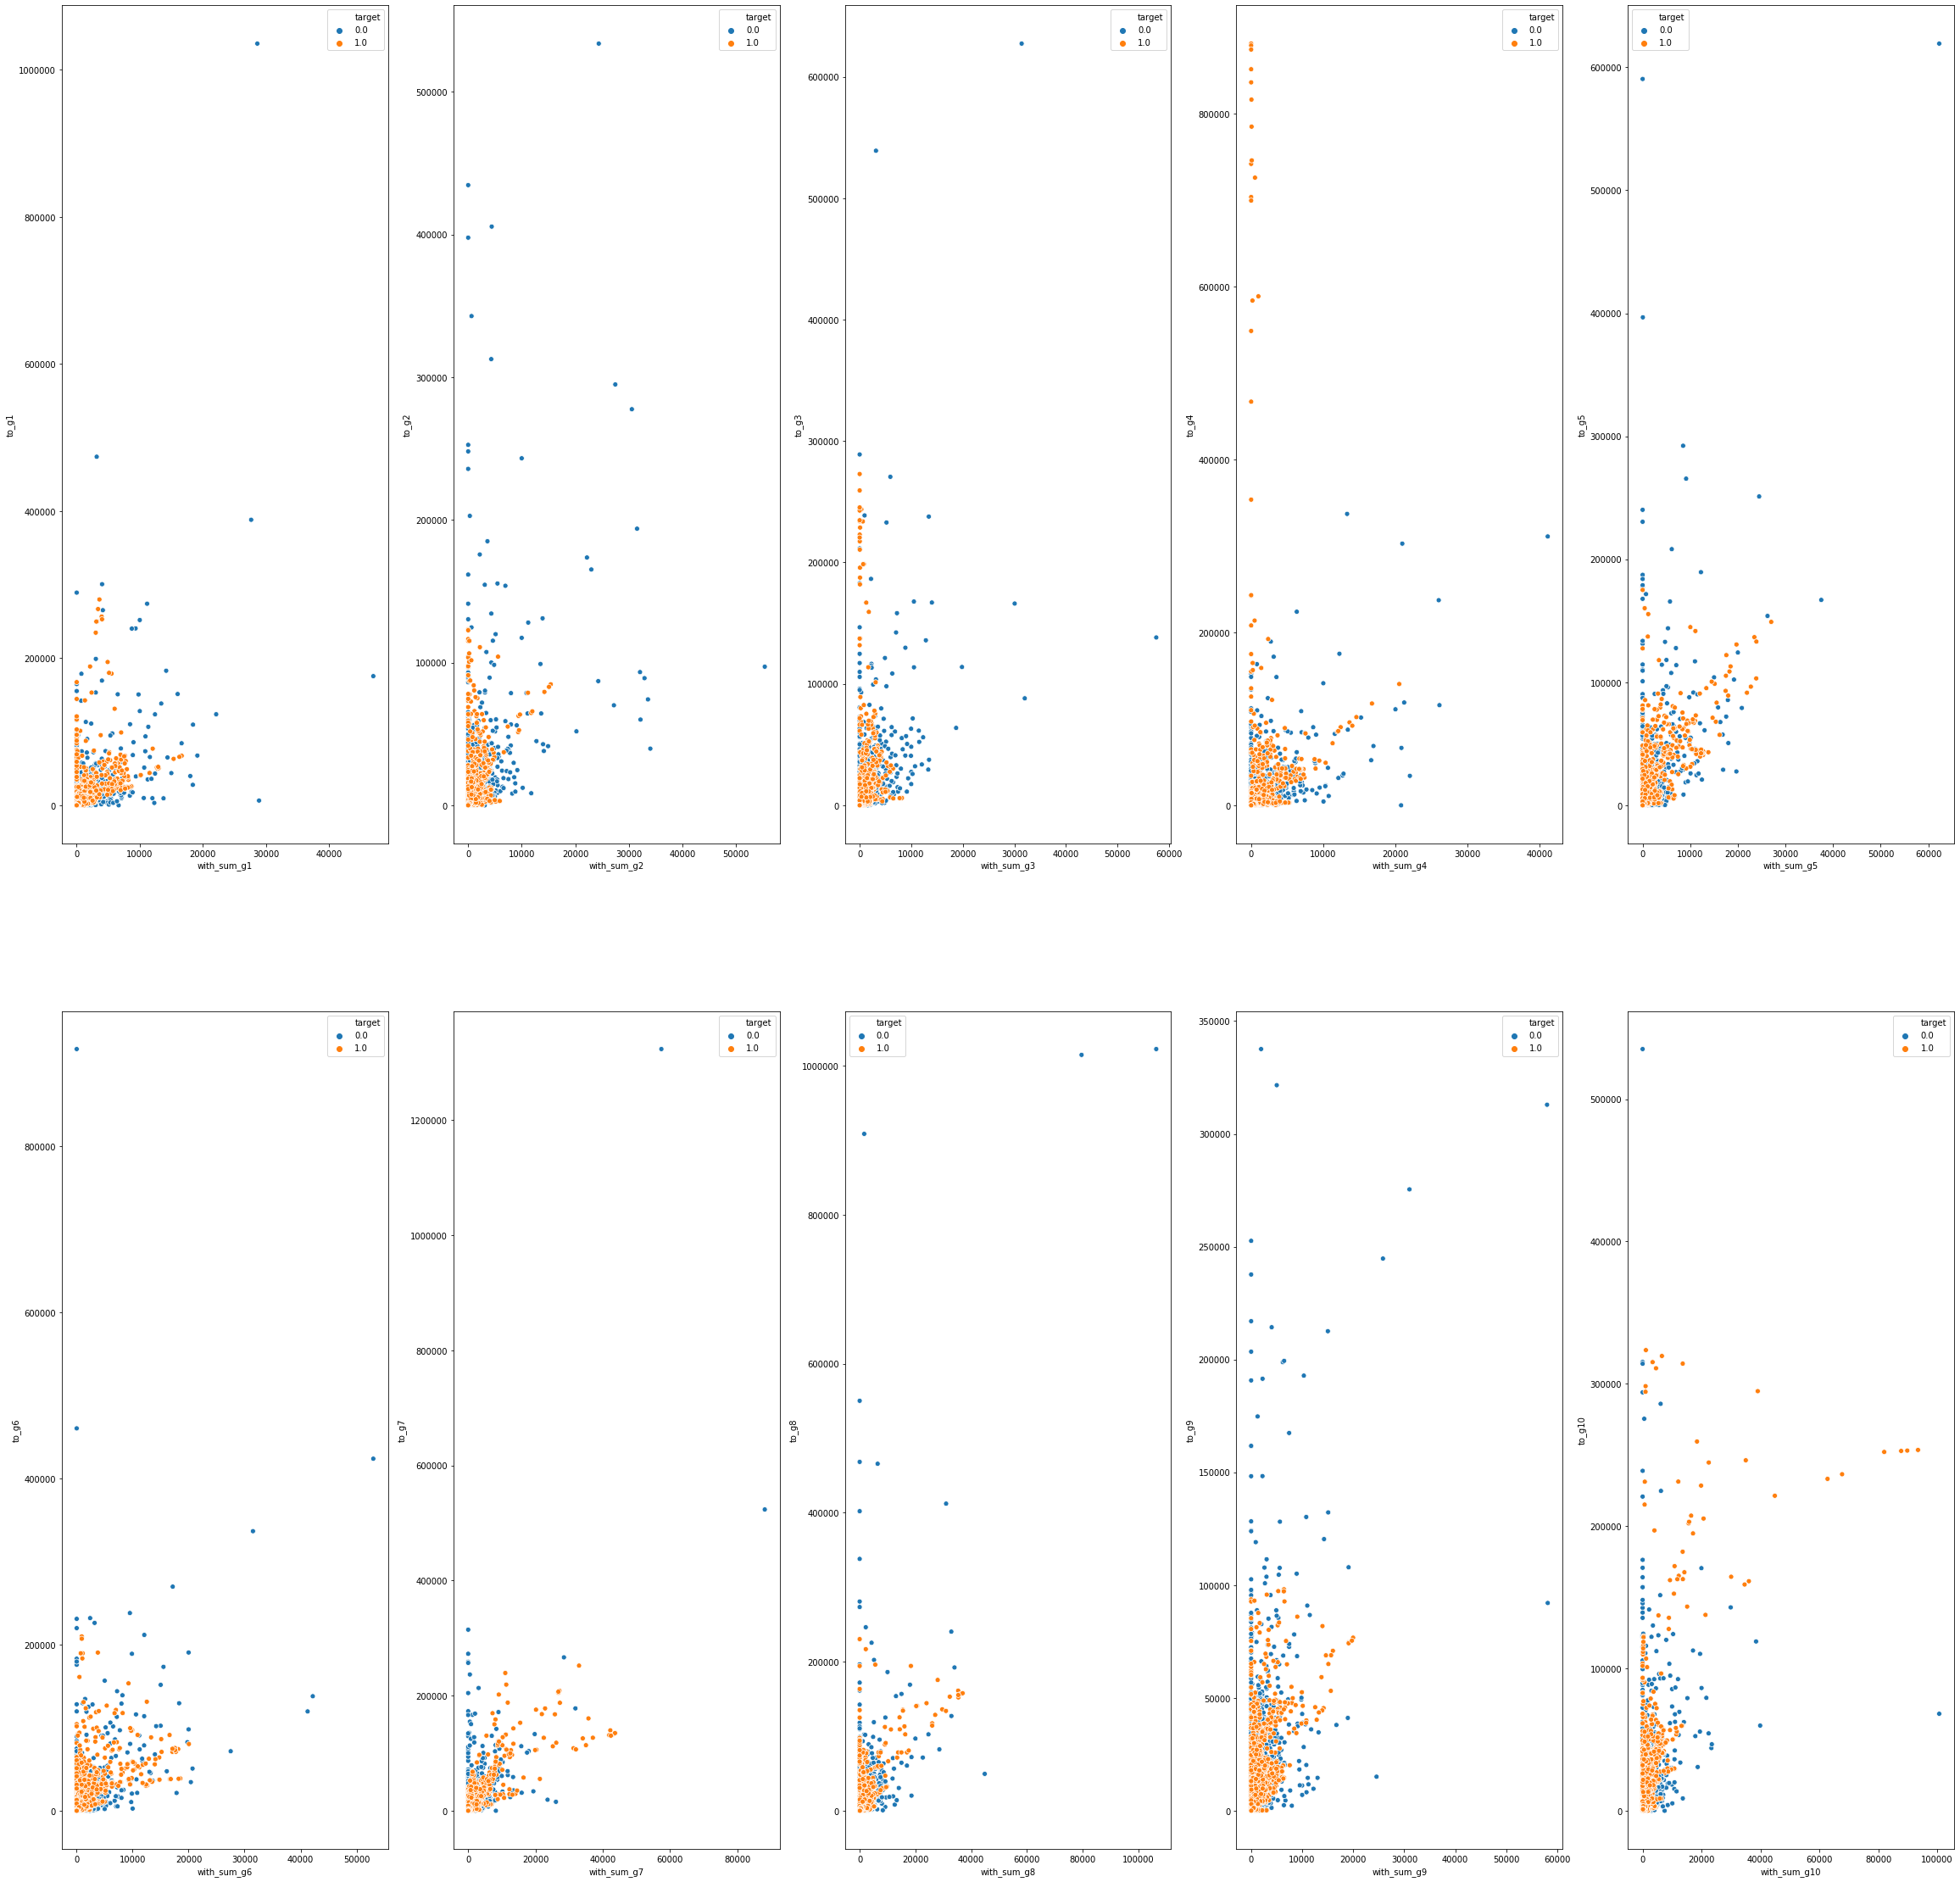

In [263]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize = (40, 40))
for wk in range( 10):
    if wk<5:
        sns.scatterplot(x='with_sum_g' + str(wk+1), y='to_g' + str(wk+1), hue="target", data=train_set, ax =axes[0, wk] )
    else:
        sns.scatterplot(x='with_sum_g' + str(wk+1), y='to_g' + str(wk+1), hue="target", data=train_set, ax = axes[1, wk-5] )

In [14]:
with_sum_cols = ['with_sum_g1', 'with_sum_g2',  'with_sum_g3', 'with_sum_g4', 'with_sum_g5', 'with_sum_g6',\
                 'with_sum_g7', 'with_sum_g8', 'with_sum_g9', 'with_sum_g10']
to_g_cols = ['to_g1', 'to_g2', 'to_g3', 'to_g4', 'to_g5', 'to_g6', 'to_g7', 'to_g8', 'to_g9', 'to_g10']

# Create temporary rows per client
train_set['mean_with_sum_cols'] =train_set[with_sum_cols].mean(axis=1)
train_set['to_g_cols'] = train_set[to_g_cols].mean(axis=1)

# Create the indicator
train_set['W_B_indicator'] = train_set[with_sum_cols].mean(axis=1) / train_set[to_g_cols].mean(axis=1)

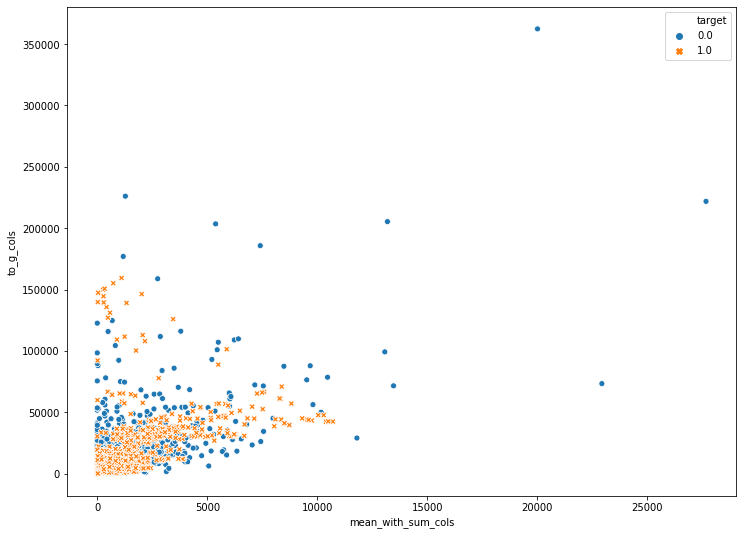

In [265]:
plt.figure(figsize=(12,9))
sns.scatterplot(x='mean_with_sum_cols' , y='to_g_cols', hue="target", style='target', data=train_set )

We remove the otliers based on the plots above. Then we re plot witout outliers

In [15]:
# Remove outliers
train_set = train_set.loc[(train_set.mean_with_sum_cols<10000) & (train_set.to_g_cols<200000)].reset_index(drop= True)

Text(0.5, 1.0, 'After outliers removal')

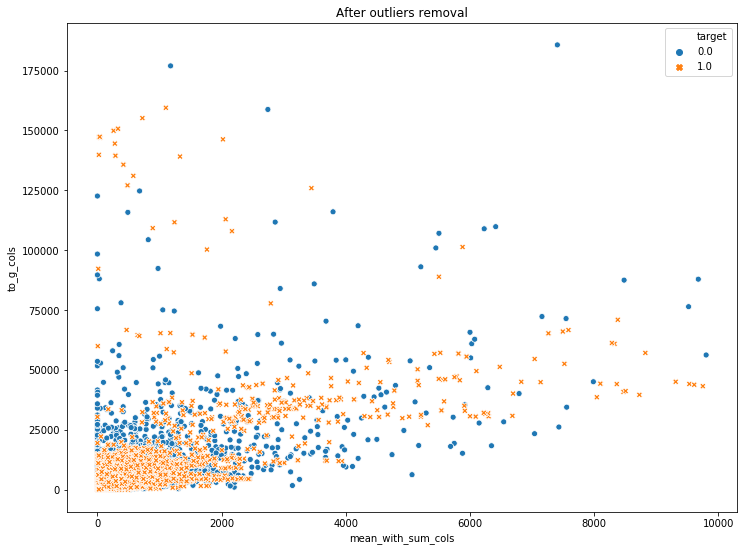

In [267]:
plt.figure(figsize=(12,9))
sns.scatterplot(x='mean_with_sum_cols' , y='to_g_cols', hue="target", style='target', data=train_set )
plt.title('After outliers removal')

## 2. Bets/deposits

For this indicator we calculate the ratio between the betting rounds per succesfull deposits. This is an indicator of how fast a player losses the money he hase bet. This might be related to his need to call the center.

In [16]:
SB_ro_g_cols = ['ro_g1', 'ro_g2', 'ro_g3', 'ro_g4', 'ro_g5', 'ro_g6', 'ro_g7', 'ro_g8', 'ro_g9', 'ro_g10' ]
succ_dep_g_cols = ['succ_dep_g1', 'succ_dep_g2', 'succ_dep_g3', 'succ_dep_g4', 'succ_dep_g5', 'succ_dep_g6', 'succ_dep_g7', 'succ_dep_g8', 'succ_dep_g9', 'succ_dep_g10' ]

# Create temporary columns per client
train_set['mean_ro_g_cols'] =train_set[SB_ro_g_cols].mean(axis=1)
train_set['mean_succ_dep_g_cols'] = train_set[succ_dep_g_cols].mean(axis=1)

# Create the indicator
train_set['B_D_indicator'] = train_set[with_sum_cols].mean(axis=1) / train_set[to_g_cols].mean(axis=1)


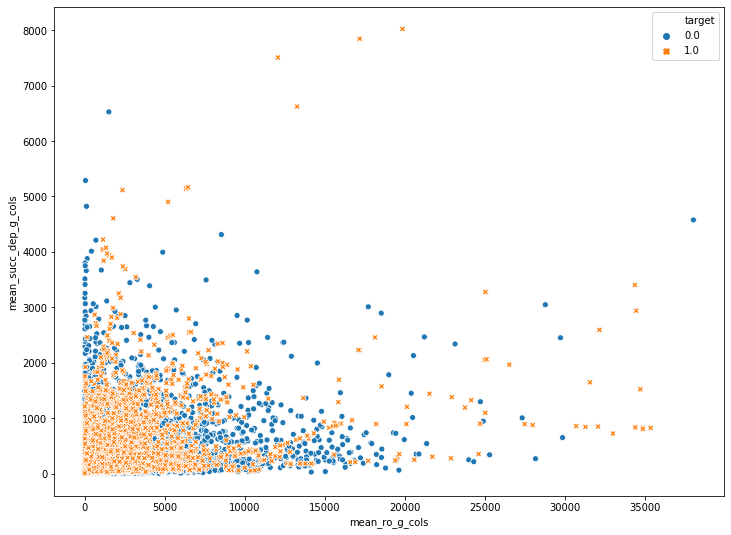

In [22]:
# Visualize
plt.figure(figsize=(12,9))
sns.scatterplot(x='mean_ro_g_cols' , y='mean_succ_dep_g_cols', hue="target", style='target', data=train_set )

In [17]:
# remove outliers based on the plot
train_set = train_set.loc[(train_set.mean_ro_g_cols<20000) & (train_set.mean_succ_dep_g_cols<4500)].reset_index(drop= True)

Text(0.5, 1.0, 'After outliers removal')

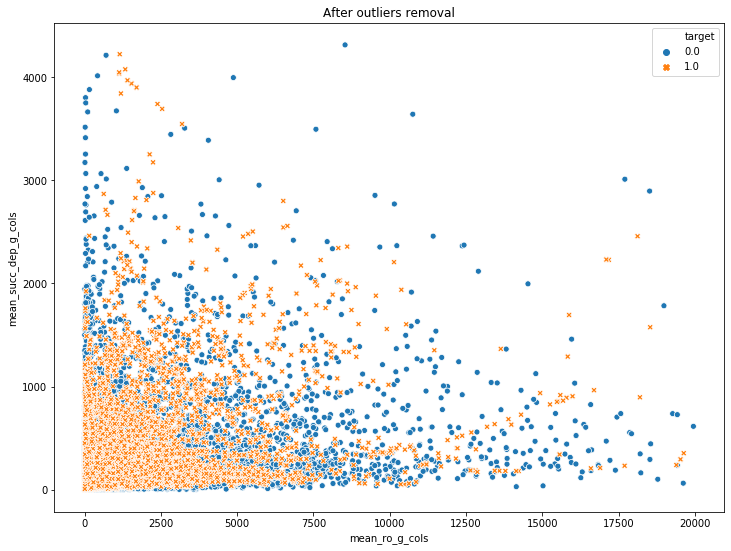

In [24]:
# Visualize
plt.figure(figsize=(12,9))
sns.scatterplot(x='mean_ro_g_cols' , y='mean_succ_dep_g_cols', hue="target", style='target', data=train_set )
plt.title('After outliers removal')

A closer look at the plot reveals that most of the clients that eventually called have the following features:
- Relatively low mean succesful deposits


## 3. Number of payments indicator

We assume that the number of discrete payment methods, will potentially cause some trouble to the client (eg. His credit card might be rejected, he cannot find the same prepaid card that he bought last time etc). 

In [18]:
pay_meth = ['pm_sum_g10','pm_sum_g9','pm_sum_g8','pm_sum_g7','pm_sum_g6','pm_sum_g5','pm_sum_g4','pm_sum_g3','pm_sum_g2','pm_sum_g1']

avg_pay_meth_0 = train_set[pay_meth].loc[train_set.target == 0].mean(axis=1).mean(axis = 0)
avg_pay_meth_1 = train_set[pay_meth].loc[train_set.target == 1].mean(axis=1).mean(axis = 0)
# Assume equal contribution to the average of the two classes
avg_pay_meth = .5*avg_pay_meth_0 + .5*avg_pay_meth_1
train_set['avg_pay_indicator'] = train_set[pay_meth].mean(axis = 1)

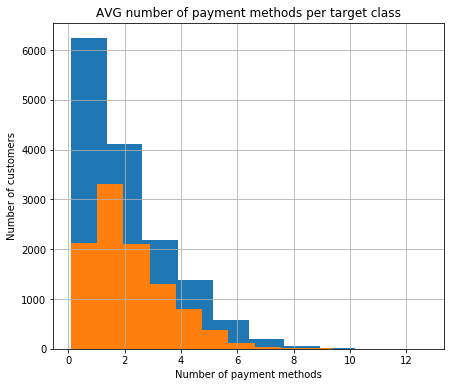

In [26]:
plt.figure(figsize = (7,6))
train_set.groupby("target").avg_pay_indicator.hist()
plt.title('AVG number of payment methods per target class')
plt.xlabel('Number of payment methods')
plt.ylabel('Number of customers')
plt.show()

In [27]:
print('Number of customers that their payment methods are less than the total average per target class: \n{}'.format(\
train_set[train_set[pay_meth].mean(axis = 1)<avg_pay_meth].groupby(by = 'target').size()))

print('Number of customers that their payment methods are more than the total average per target class: \n{}'.format(\
train_set[train_set[pay_meth].mean(axis = 1)>avg_pay_meth].groupby(by = 'target').size()))

Number of customers that their payment methods are less than the total average per target class: 
target
0.0    9036
1.0    5949
dtype: int64
Number of customers that their payment methods are more than the total average per target class: 
target
0.0    5740
1.0    4244
dtype: int64


Probably not very usefull indicator. The trends for the 2 classes are the same. No obvious trend that can help in separating the 2 classes

## 4. Total amount on SB vs GOC indicator

In this part we create an indicator named `SBvsGoc_amount`. We assume that the nature of the game type that a client plays and the average amount that he wagered, leads him to a decision, so as to call or not call the customer center. 

In [19]:
GOC_to_g_cols = ['GOC_to_g10', 'GOC_to_g9', 'GOC_to_g8', 'GOC_to_g7', 'GOC_to_g6', 'GOC_to_g5', 'GOC_to_g4', 'GOC_to_g3', 'GOC_to_g2', 'GOC_to_g1']
SB_to_g_cols = ['SB_to_g10', 'SB_to_g9', 'SB_to_g8', 'SB_to_g7', 'SB_to_g6', 'SB_to_g5', 'SB_to_g4', 'SB_to_g3', 'SB_to_g2','SB_to_g1']

# Amount on SB vs COG
train_set['SBvsGoc_amount'] = train_set[SB_to_g_cols].sum(axis = 1) / train_set[GOC_to_g_cols].sum(axis = 1)

# remove inf values
train_set['SBvsGoc_amount'] = train_set['SBvsGoc_amount'].replace(np.inf, 1.01)

# Calculate the correlation between the 2 indicators
print('The correlation between the indicator  "SBvsGoc_amount" and the target class is: ',\
      train_set['target'].corr(train_set['SBvsGoc_amount'], 'pearson'))

The correlation between the indicator  "SBvsGoc_amount" and the target class is:  0.014683561512780994


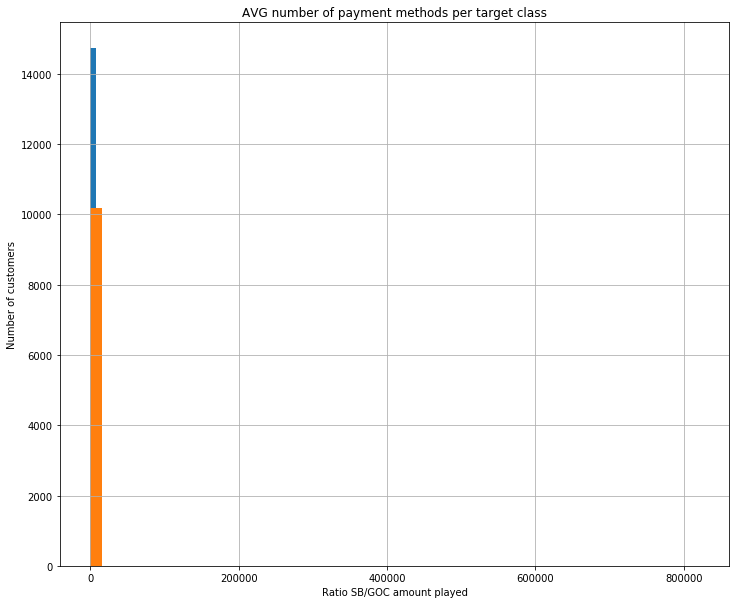

In [32]:
plt.figure(figsize = (12,10))
train_set.groupby("target").SBvsGoc_amount.hist(bins = 50)
plt.title('AVG number of payment methods per target class')
plt.xlabel('Ratio SB/GOC amount played')
plt.ylabel('Number of customers')

plt.show()

## PCA for dimensionality reduction 

In this part we use Principal Components Analysis for the attributes that contain information for 10 weeks in order to eliminate the columns. We demand from the custom PCA class to return as many Principal Components as needed in order to contain - the standartly used- 95% of the total information.

In [20]:
# Have a visual test before substituting the existing columns with the Principal Components

# reorder columns
pca_cols = [x for x in train_set.columns.tolist() if x != 'target'] + ['target']
train_set_reduced = train_set[pca_cols]

# Normalize dataset
train_set_reduced = pd.concat([norm_(train_set_reduced.iloc[:, :-1]), train_set_reduced.iloc[:, -1]], axis = 1)

#train_set_reduced.columns
for ii in range(22):
    columns = train_set_reduced.columns.tolist()[ii*10: (ii+1)*10] + ['target']
    #print(columns)
    df = train_set.loc[:, columns]
    print('PCA for `', columns, '` features')
    pca = custom_PCA(df, 0.90)
    pca_df = pca.fit()
    print('\n')

PCA for ` ['days_g10', 'days_g9', 'days_g8', 'days_g7', 'days_g6', 'days_g5', 'days_g4', 'days_g3', 'days_g2', 'days_g1', 'target'] ` features
Final selection is the first 4 PCs
Dimensionaly reduced matrix shape (25261, 5)


PCA for ` ['ro_g10', 'ro_g9', 'ro_g8', 'ro_g7', 'ro_g6', 'ro_g5', 'ro_g4', 'ro_g3', 'ro_g2', 'ro_g1', 'target'] ` features
Final selection is the first 6 PCs
Dimensionaly reduced matrix shape (25261, 7)


PCA for ` ['to_g10', 'to_g9', 'to_g8', 'to_g7', 'to_g6', 'to_g5', 'to_g4', 'to_g3', 'to_g2', 'to_g1', 'target'] ` features
Final selection is the first 7 PCs
Dimensionaly reduced matrix shape (25261, 8)


PCA for ` ['gw_g10', 'gw_g9', 'gw_g8', 'gw_g7', 'gw_g6', 'gw_g5', 'gw_g4', 'gw_g3', 'gw_g2', 'gw_g1', 'target'] ` features
Final selection is the first 1 PCs
Dimensionaly reduced matrix shape (25261, 2)


PCA for ` ['mar_g10', 'mar_g9', 'mar_g8', 'mar_g7', 'mar_g6', 'mar_g5', 'mar_g4', 'mar_g3', 'mar_g2', 'mar_g1', 'target'] ` features
Final selection is the firs

From the above implementation of PCA, it is shown that it cannot contribute significantly in the dimensionality reduction, since more than five Principal Components are kept for each group most of the times. However we can see that for group of features named `gw_g{}` PCA returned only one PC, hence we are going to implement PCA to the dataset only for this group of features that indicate the `Total game win amount in EUR during week`.

In [24]:
# Initialize custom PCA class
pca = custom_PCA(train_set_reduced[['gw_g10', 'gw_g9', 'gw_g8', 'gw_g7', \
                                 'gw_g6', 'gw_g5', 'gw_g4', 'gw_g3', 'gw_g2', 'gw_g1', 'target']], 0.90)
# Fit
pca_df = pca.fit()
# Assign the Principal Component to a new column
train_set_reduced['gw_g_PC'] = pca_df.PC_1
# Drop the columns that now are represented by 'gw_g_PC'
train_set_reduced.drop(['gw_g10', 'gw_g9', 'gw_g8', 'gw_g7','gw_g6', 'gw_g5', 'gw_g4', 'gw_g3', 'gw_g2', 'gw_g1'], axis = 1, inplace = True)

# reorder columns
train_set_reduced = train_set_reduced[[x for x in train_set_reduced.columns.tolist() if x != 'target'] + ['target']]

In [25]:
train_set_reduced.shape

(25261, 258)

## Collinearity examination 

We are going to examine the colinearity of the attributes. At this point the colinear attributes are going to be removed. This will enhance the model's predictability as well as the interpretability.

In [28]:
# Correlation matrix using 'Spearman correlation'
corr_matrix = train_set_reduced.iloc[:, :-1].corr('spearman').abs()

colinearity = (corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
                                         .stack()
                                         .sort_values(ascending=False))

In [60]:
# View of of the colinearities with colinearity more than 97%
with pd.option_context('display.max_rows', None, 'display.max_columns', None): 
    print(colinearity.loc[(colinearity.values>0.970)])

days_g10                       days_since_last_SE_GI_wrt_max    1.000000
SE_GI_avg_datediff             days_since_last_SE_GI_wrt_std    1.000000
SE_GI_min_datediff             SE_GI_std_datediff               1.000000
                               SE_GI_avg_datediff               1.000000
SE_GI_max_datediff             gw_g_PC                          1.000000
ro_g10                         SE_GI_std_datediff               1.000000
                               days_since_last_SE_GI_wrt_max    1.000000
days_since_last_SE_GI_wrt_max  gw_g_PC                          1.000000
days_since_last_SE_GI_wrt_min  days_since_last_SE_GI_wrt_avg    1.000000
                               days_since_last_SE_GI_wrt_std    1.000000
ro_g10                         days_since_last_SE_GI_wrt_min    1.000000
                               days_since_last_SE_GI_wrt_avg    1.000000
                               days_since_last_SE_GI_wrt_std    1.000000
                               gw_g_PC             

In [61]:
# Set threshold for the correlation at 98.7%
colinear_pairs_tuple = colinearity.loc[colinearity.values>0.98].index.tolist()
# get unique attributes from list
colinear_pairs_list = set([x for y in colinear_pairs_tuple for x in y])

C:\Users\andre\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  """
C:\Users\andre\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
C:\Users\andre\Anaconda3\lib\site-packages\seaborn\axisgrid.py:1675: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(height, height))


<Figure size 432x288 with 0 Axes>

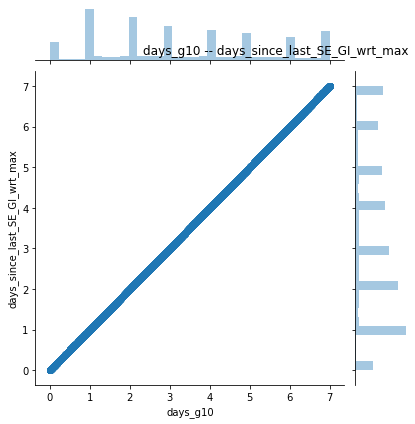

<Figure size 432x288 with 0 Axes>

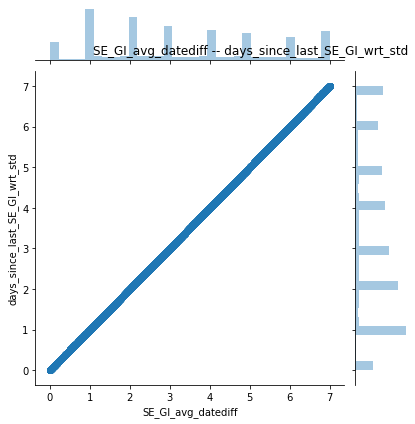

<Figure size 432x288 with 0 Axes>

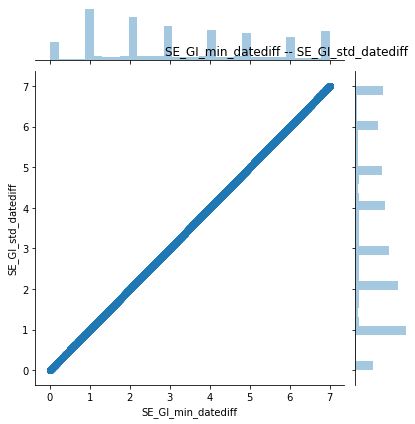

<Figure size 432x288 with 0 Axes>

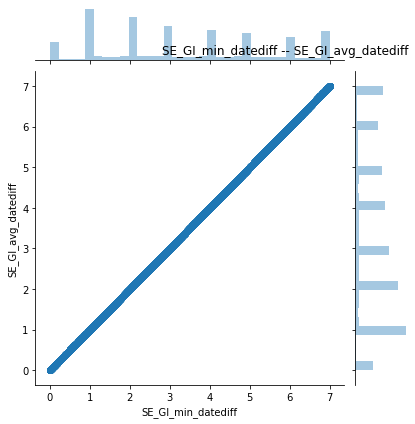

<Figure size 432x288 with 0 Axes>

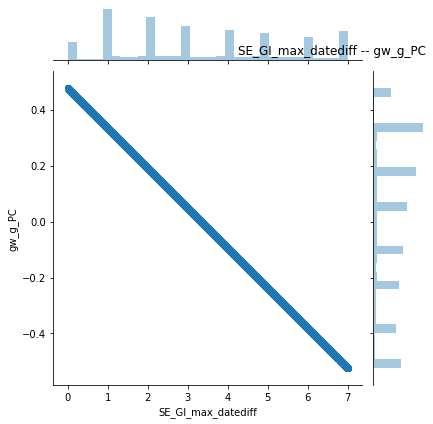

<Figure size 432x288 with 0 Axes>

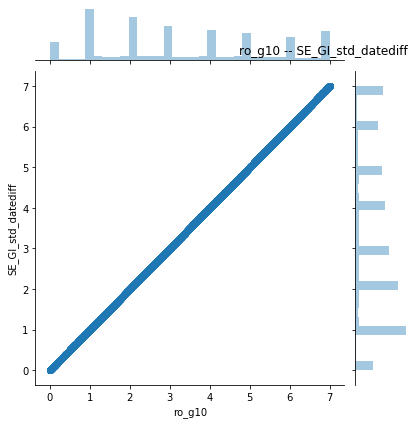

<Figure size 432x288 with 0 Axes>

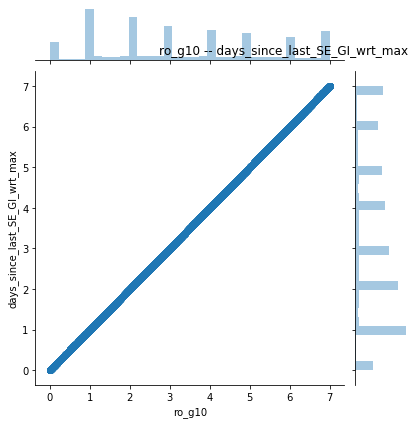

<Figure size 432x288 with 0 Axes>

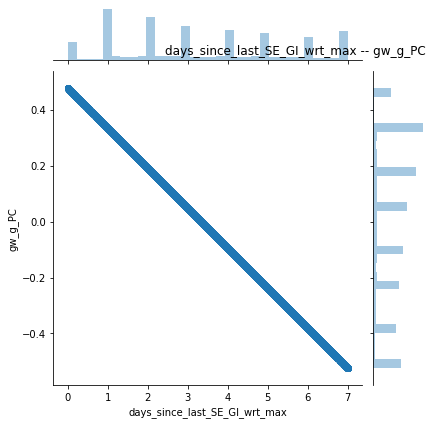

<Figure size 432x288 with 0 Axes>

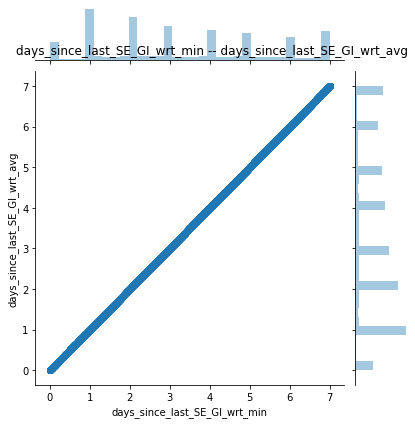

<Figure size 432x288 with 0 Axes>

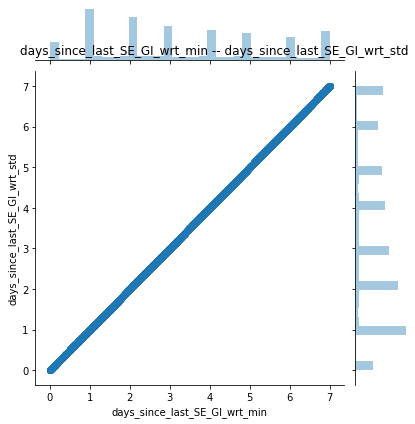

<Figure size 432x288 with 0 Axes>

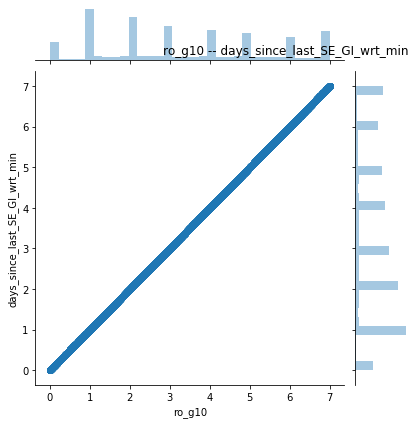

<Figure size 432x288 with 0 Axes>

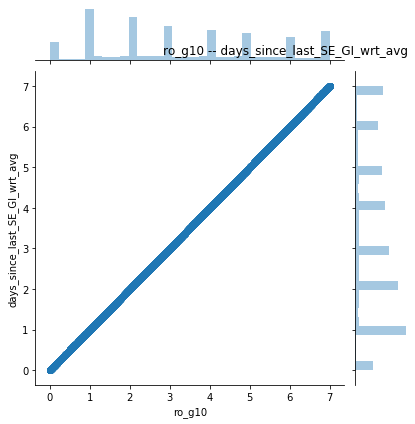

<Figure size 432x288 with 0 Axes>

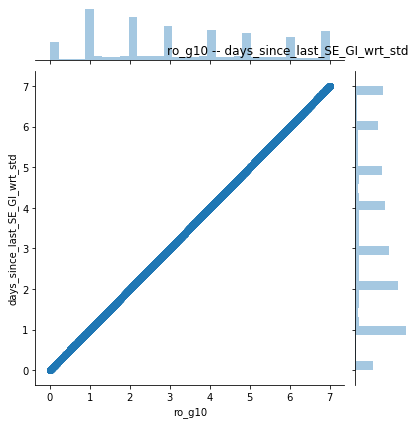

<Figure size 432x288 with 0 Axes>

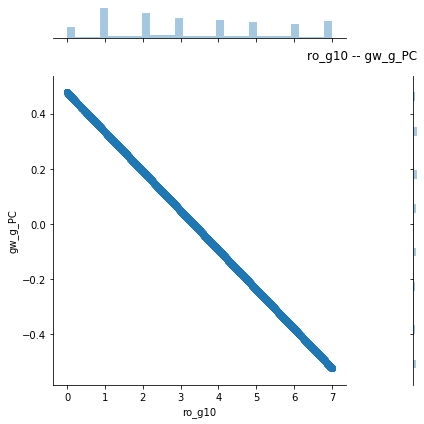

<Figure size 432x288 with 0 Axes>

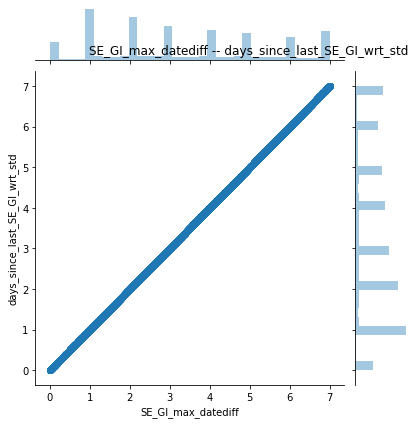

<Figure size 432x288 with 0 Axes>

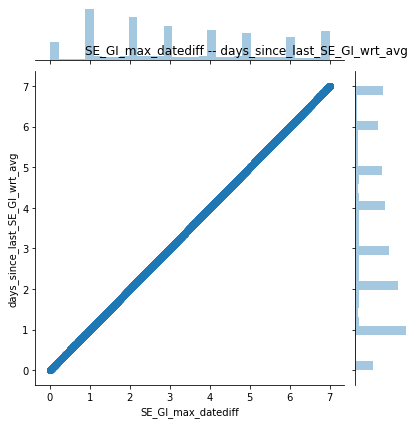

<Figure size 432x288 with 0 Axes>

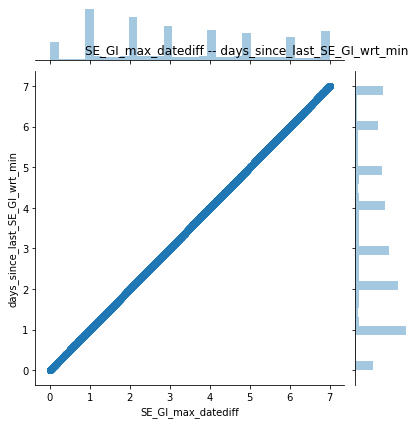

<Figure size 432x288 with 0 Axes>

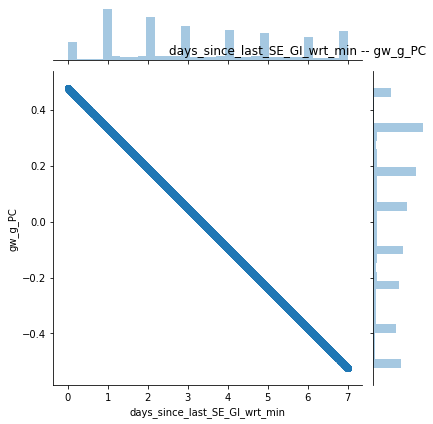

<Figure size 432x288 with 0 Axes>

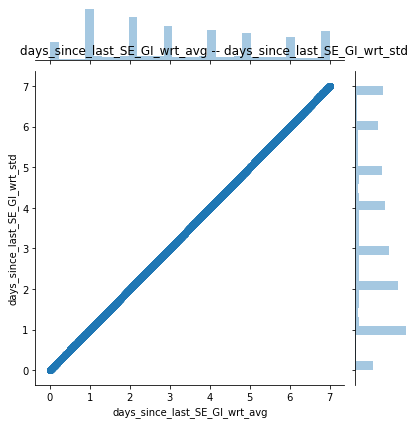

<Figure size 432x288 with 0 Axes>

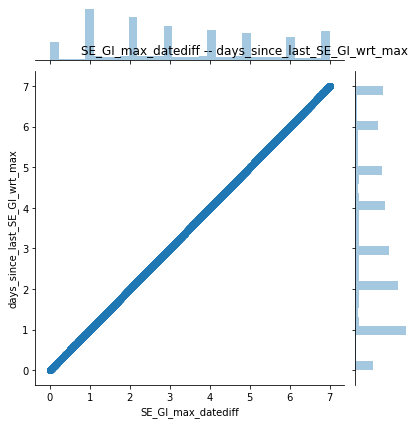

<Figure size 432x288 with 0 Axes>

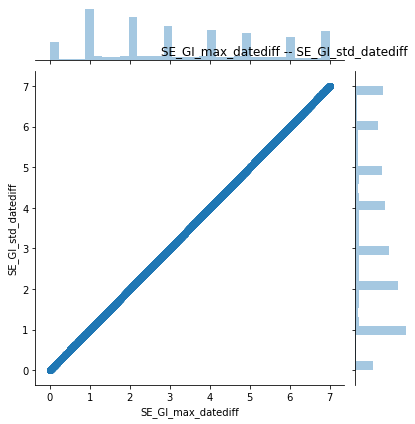

<Figure size 432x288 with 0 Axes>

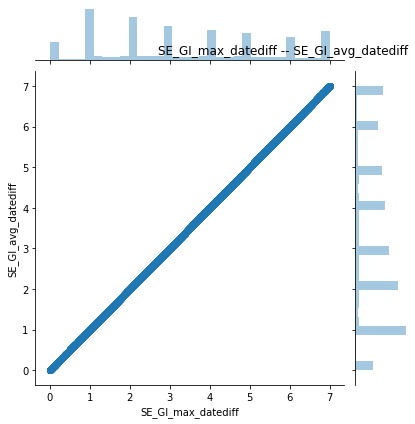

<Figure size 432x288 with 0 Axes>

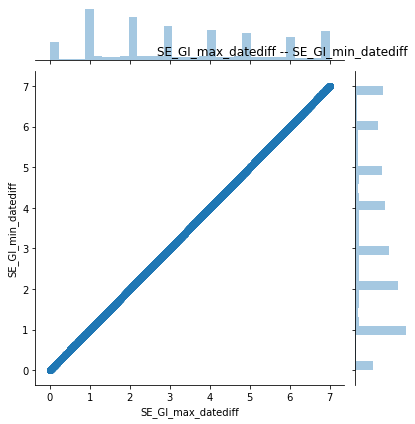

<Figure size 432x288 with 0 Axes>

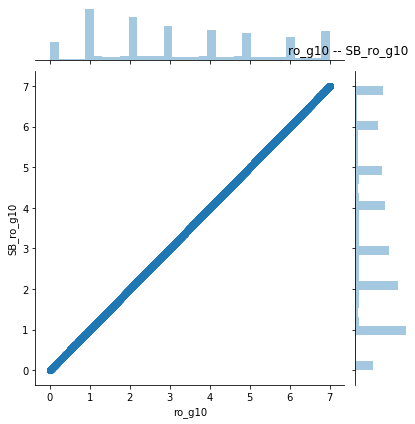

<Figure size 432x288 with 0 Axes>

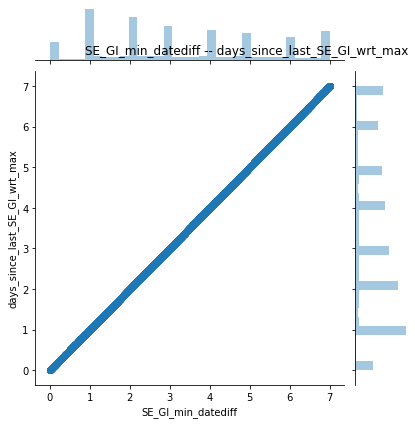

<Figure size 432x288 with 0 Axes>

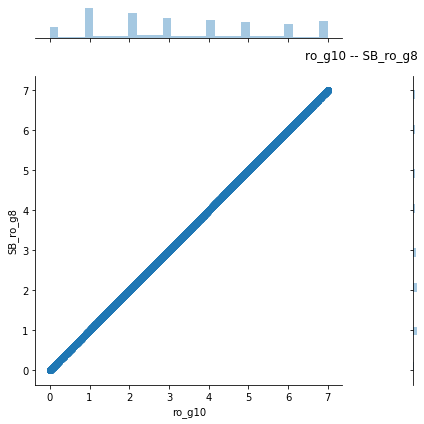

<Figure size 432x288 with 0 Axes>

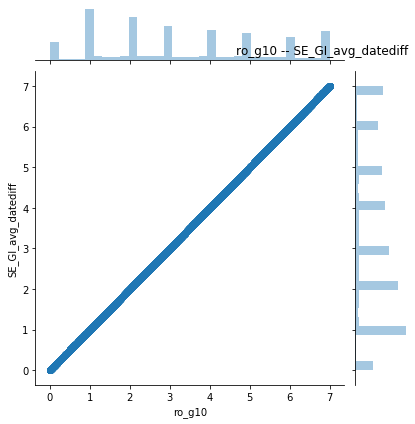

<Figure size 432x288 with 0 Axes>

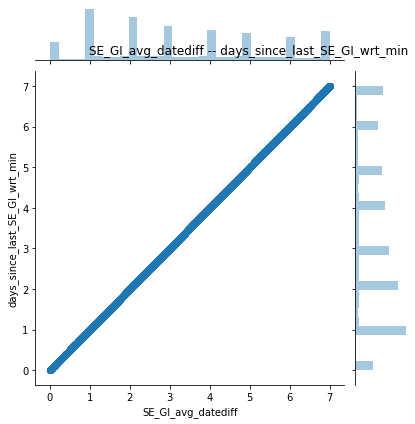

<Figure size 432x288 with 0 Axes>

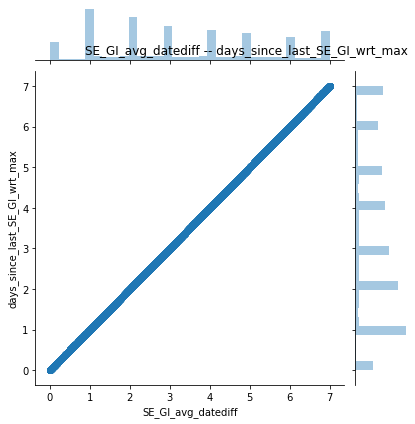

<Figure size 432x288 with 0 Axes>

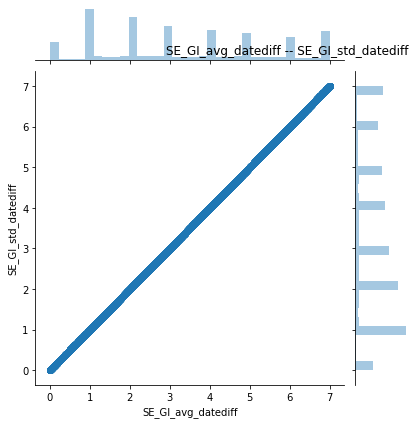

<Figure size 432x288 with 0 Axes>

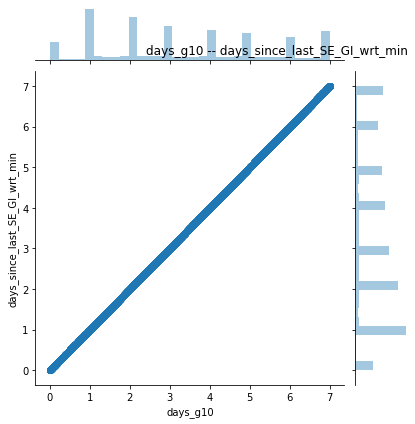

<Figure size 432x288 with 0 Axes>

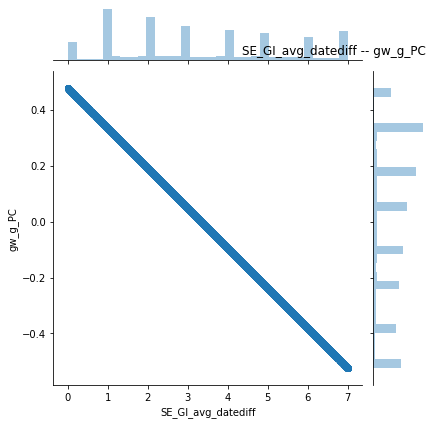

<Figure size 432x288 with 0 Axes>

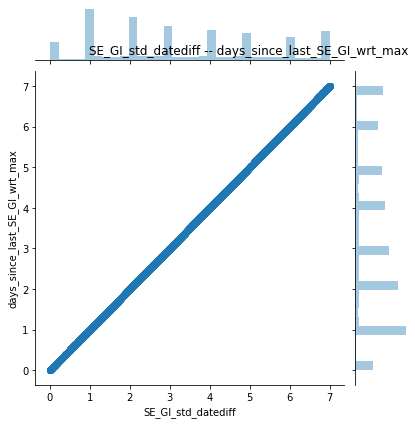

<Figure size 432x288 with 0 Axes>

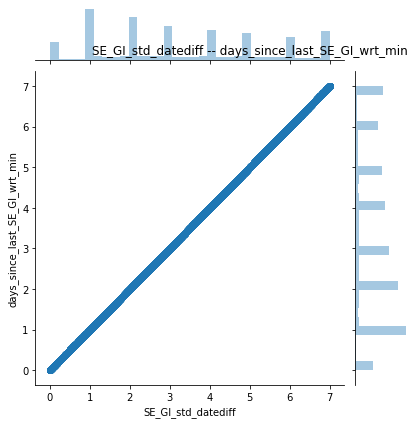

<Figure size 432x288 with 0 Axes>

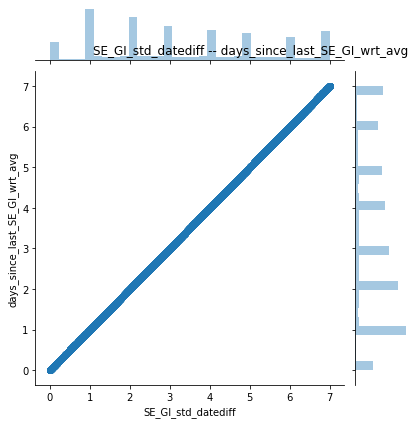

<Figure size 432x288 with 0 Axes>

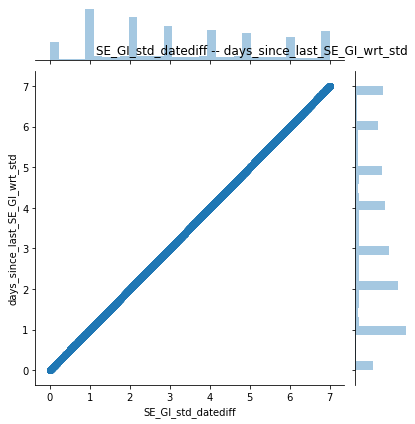

<Figure size 432x288 with 0 Axes>

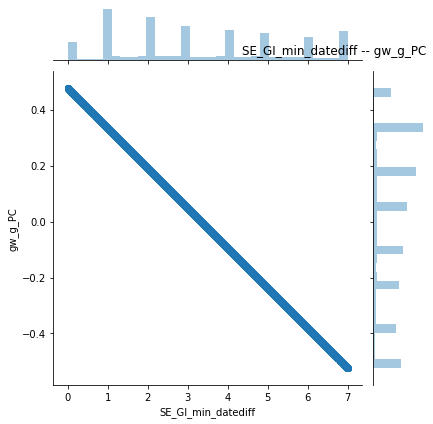

<Figure size 432x288 with 0 Axes>

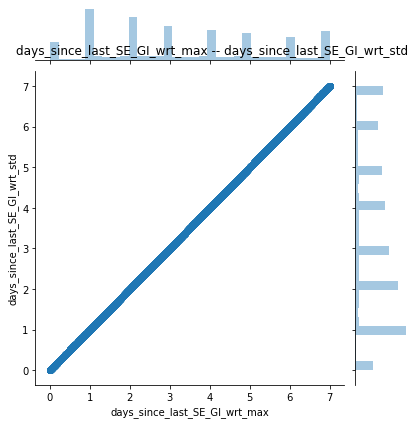

<Figure size 432x288 with 0 Axes>

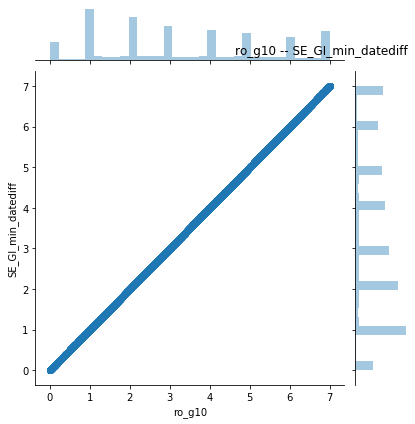

<Figure size 432x288 with 0 Axes>

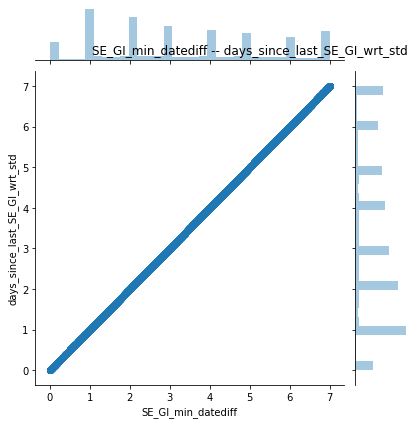

<Figure size 432x288 with 0 Axes>

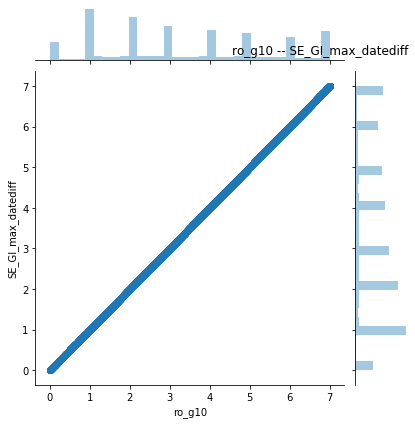

<Figure size 432x288 with 0 Axes>

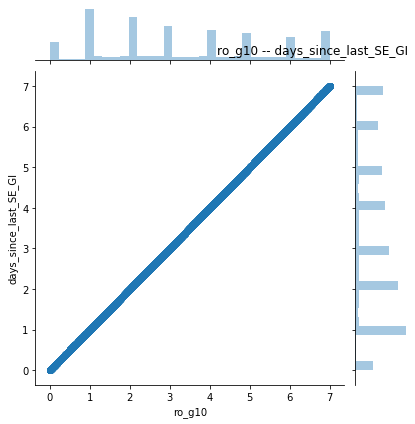

<Figure size 432x288 with 0 Axes>

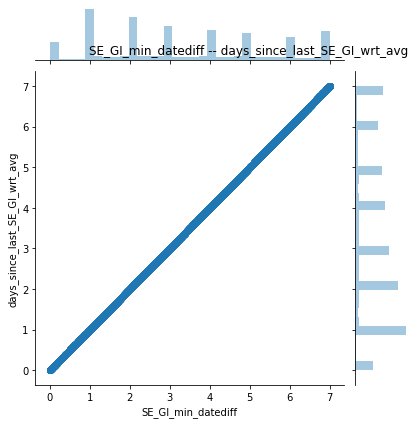

<Figure size 432x288 with 0 Axes>

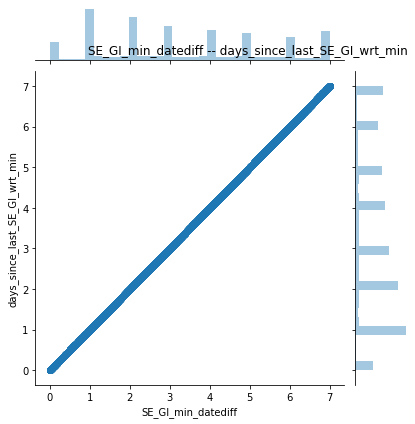

<Figure size 432x288 with 0 Axes>

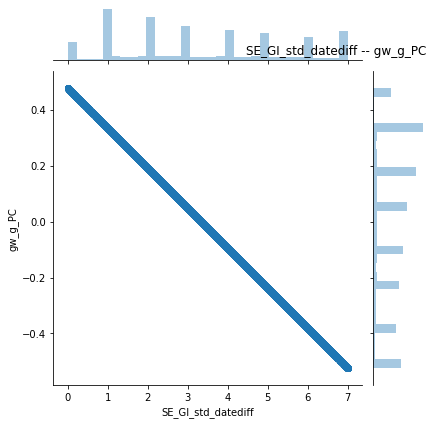

<Figure size 432x288 with 0 Axes>

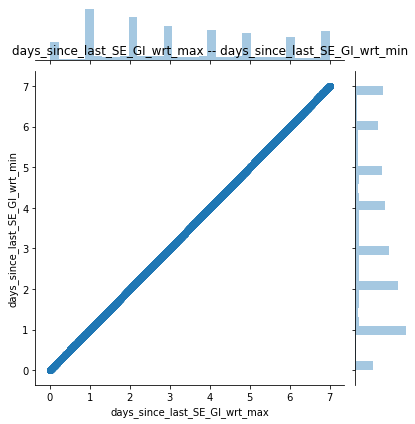

<Figure size 432x288 with 0 Axes>

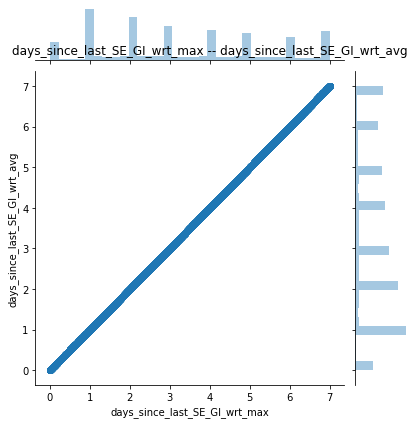

<Figure size 432x288 with 0 Axes>

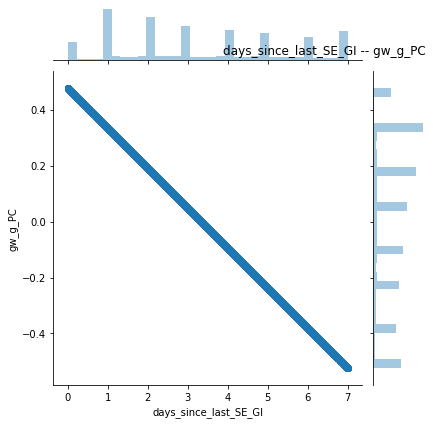

<Figure size 432x288 with 0 Axes>

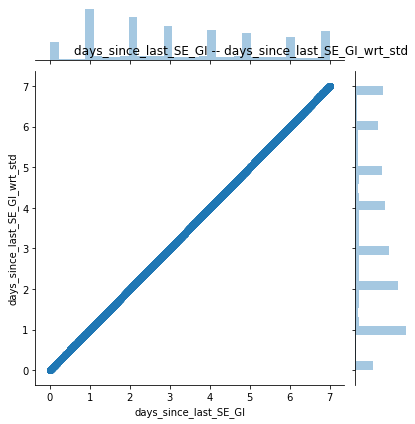

<Figure size 432x288 with 0 Axes>

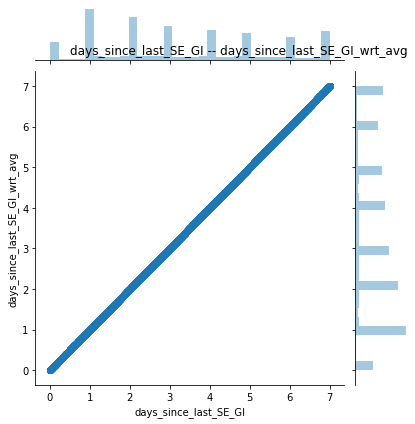

<Figure size 432x288 with 0 Axes>

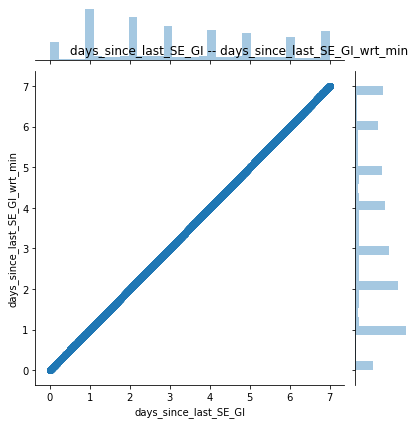

<Figure size 432x288 with 0 Axes>

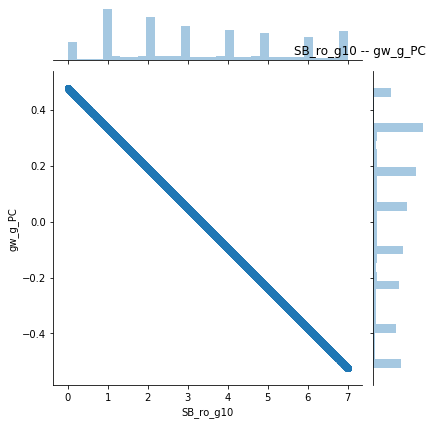

<Figure size 432x288 with 0 Axes>

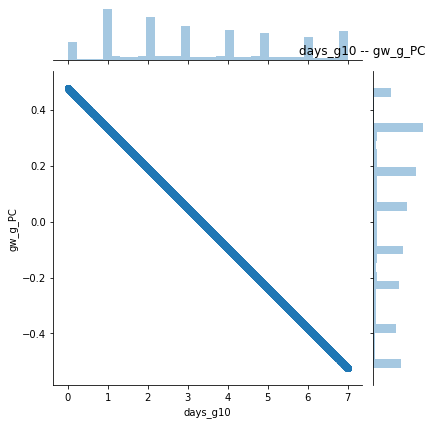

<Figure size 432x288 with 0 Axes>

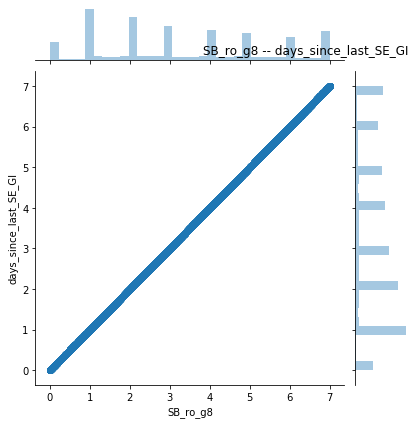

<Figure size 432x288 with 0 Axes>

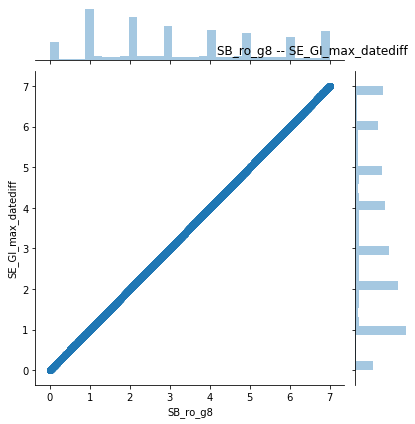

<Figure size 432x288 with 0 Axes>

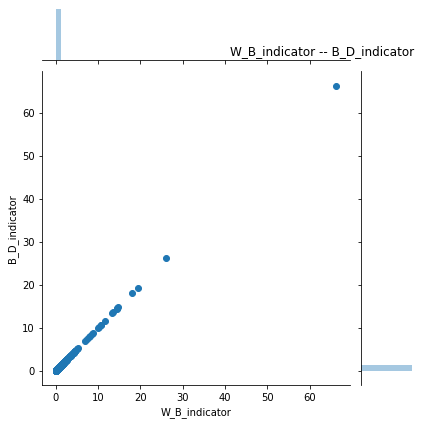

<Figure size 432x288 with 0 Axes>

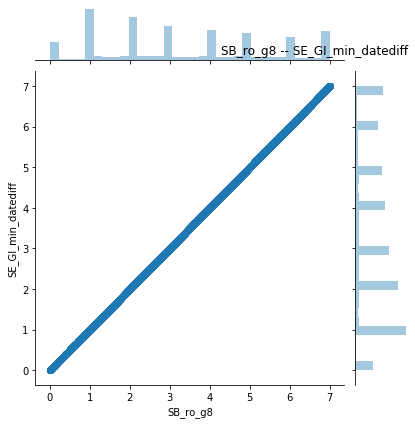

<Figure size 432x288 with 0 Axes>

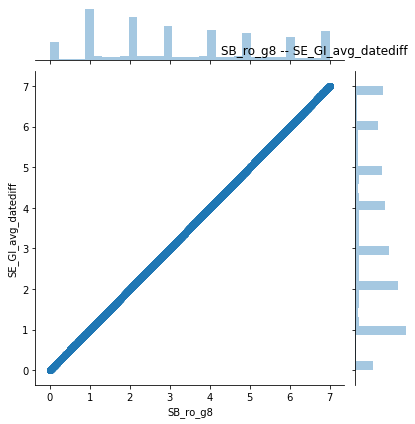

<Figure size 432x288 with 0 Axes>

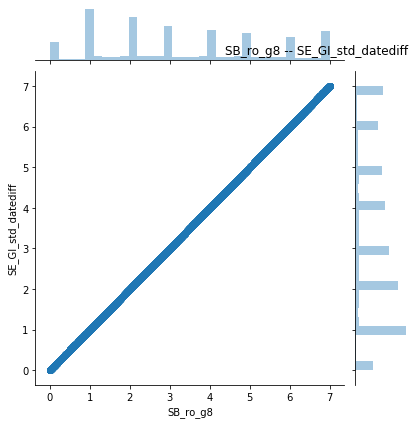

<Figure size 432x288 with 0 Axes>

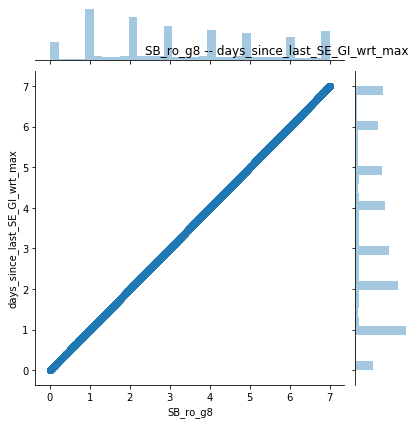

<Figure size 432x288 with 0 Axes>

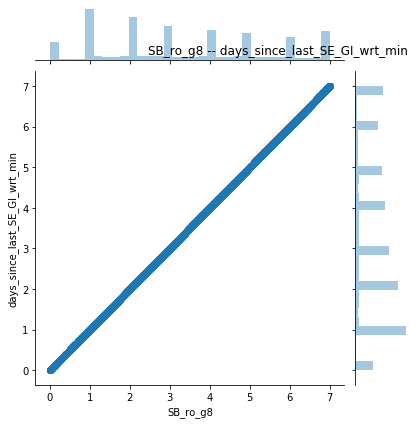

<Figure size 432x288 with 0 Axes>

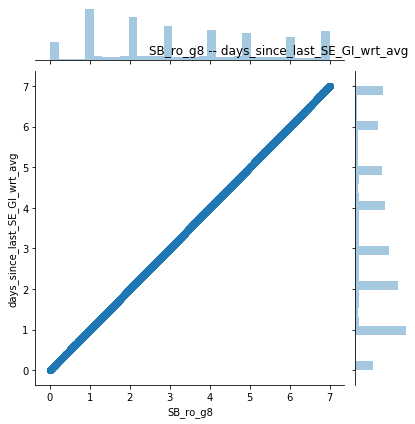

<Figure size 432x288 with 0 Axes>

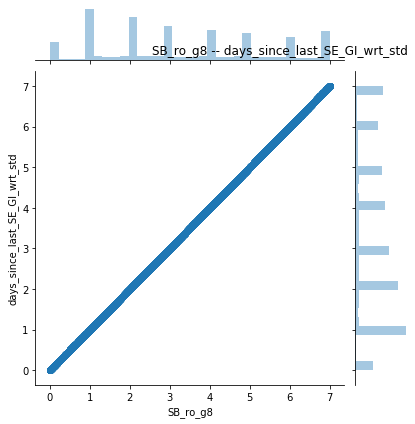

<Figure size 432x288 with 0 Axes>

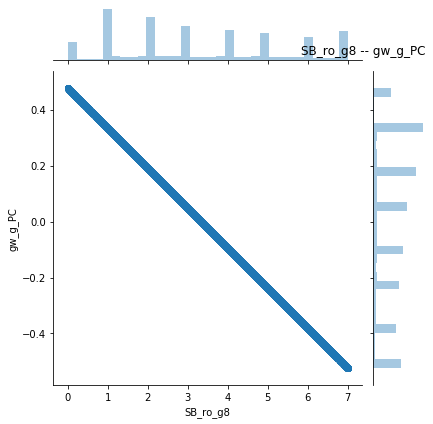

<Figure size 432x288 with 0 Axes>

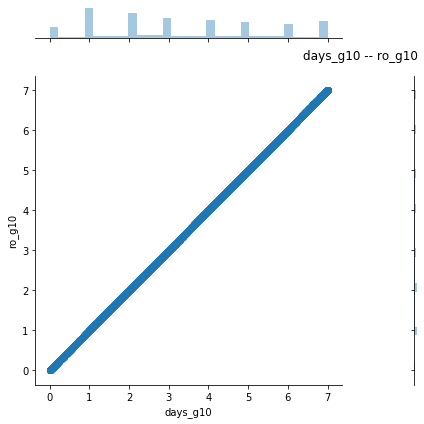

<Figure size 432x288 with 0 Axes>

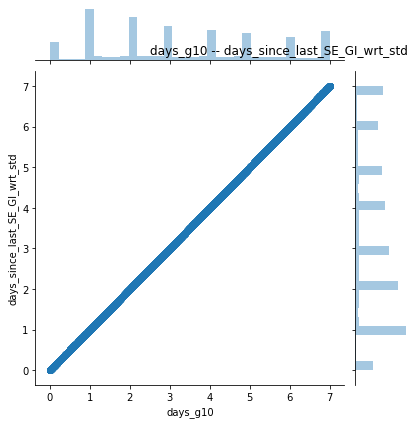

<Figure size 432x288 with 0 Axes>

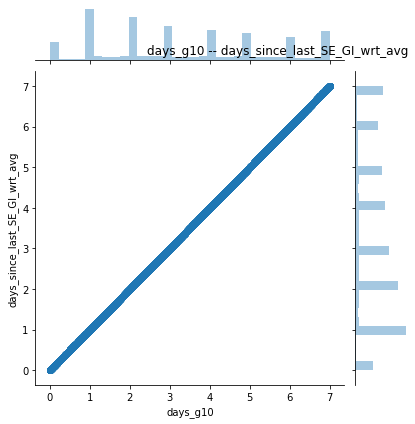

<Figure size 432x288 with 0 Axes>

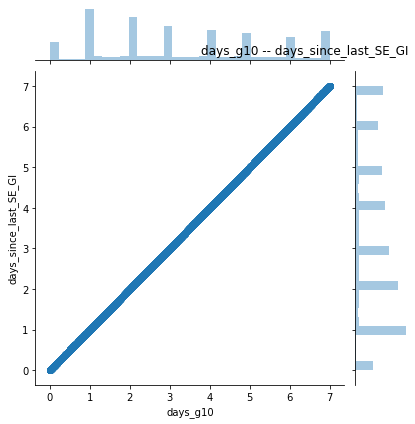

<Figure size 432x288 with 0 Axes>

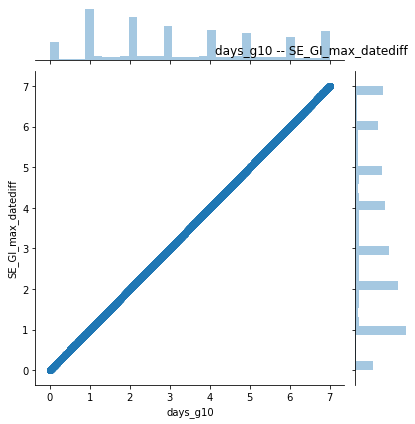

<Figure size 432x288 with 0 Axes>

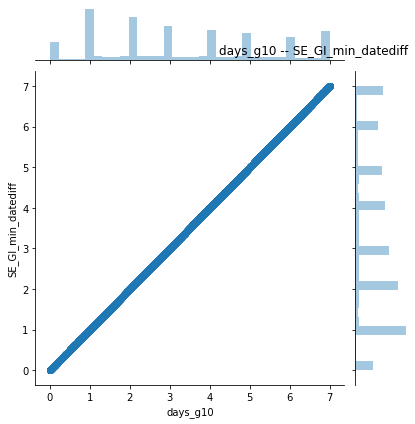

<Figure size 432x288 with 0 Axes>

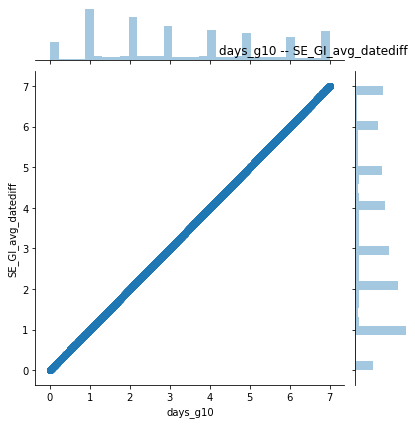

<Figure size 432x288 with 0 Axes>

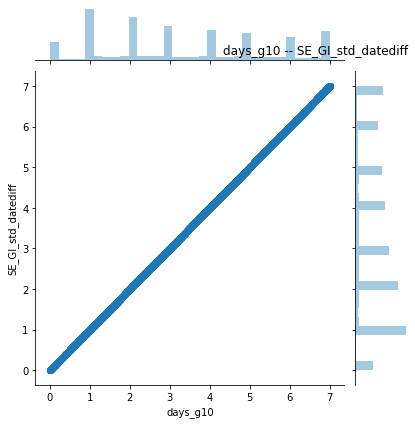

<Figure size 432x288 with 0 Axes>

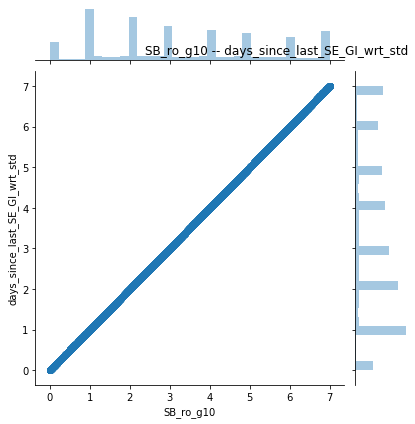

<Figure size 432x288 with 0 Axes>

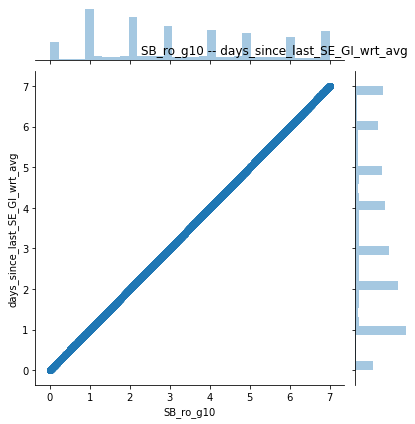

<Figure size 432x288 with 0 Axes>

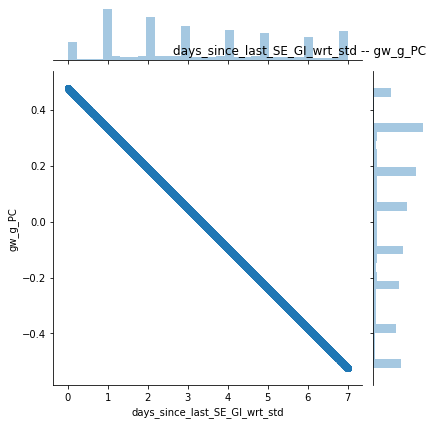

<Figure size 432x288 with 0 Axes>

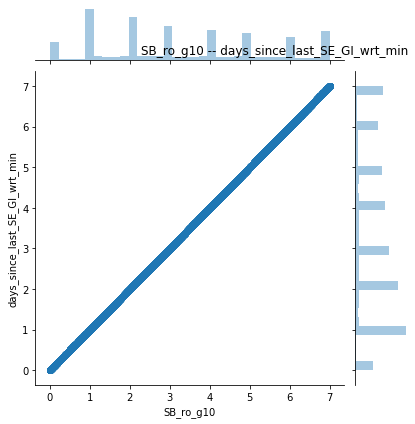

<Figure size 432x288 with 0 Axes>

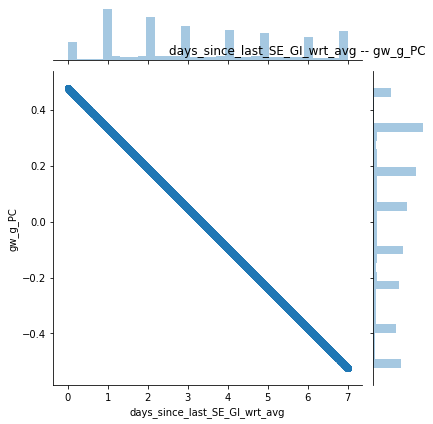

<Figure size 432x288 with 0 Axes>

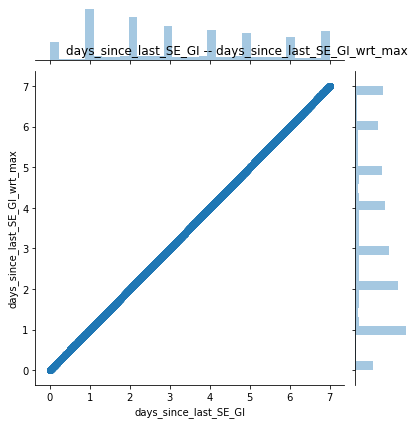

<Figure size 432x288 with 0 Axes>

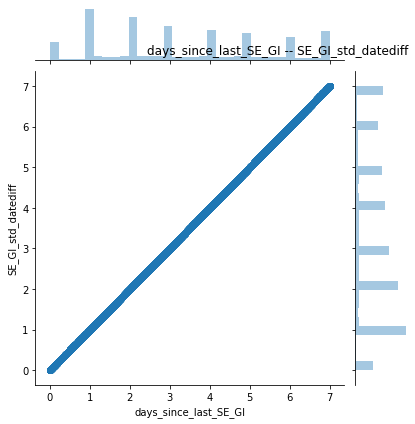

<Figure size 432x288 with 0 Axes>

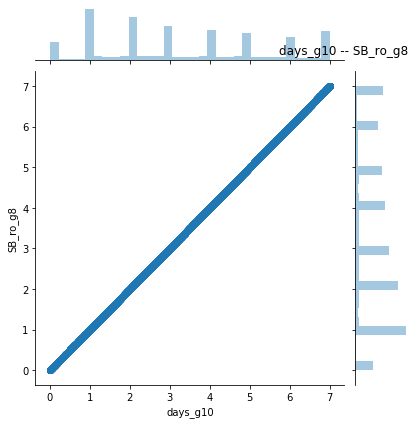

<Figure size 432x288 with 0 Axes>

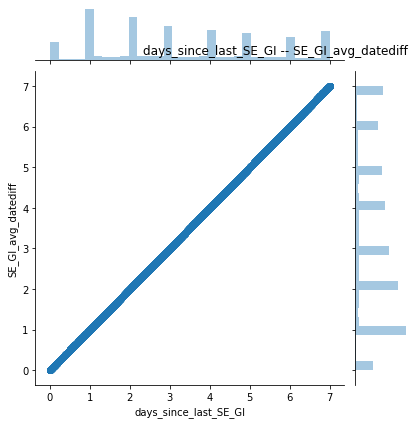

<Figure size 432x288 with 0 Axes>

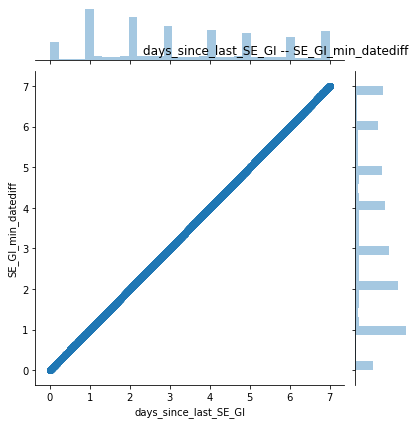

<Figure size 432x288 with 0 Axes>

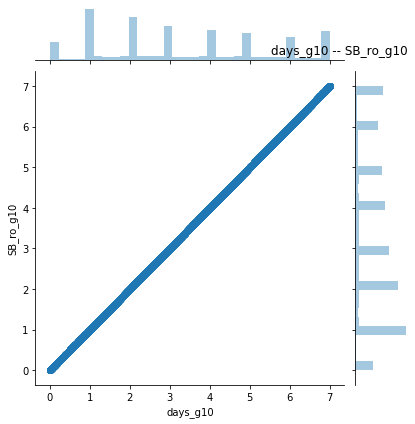

<Figure size 432x288 with 0 Axes>

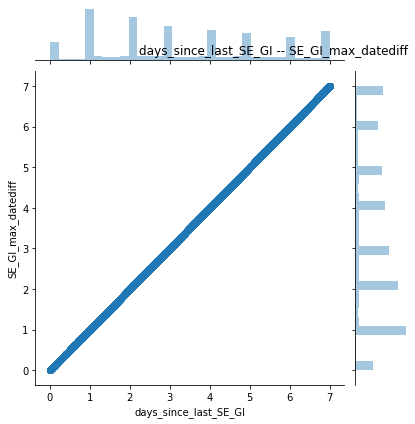

<Figure size 432x288 with 0 Axes>

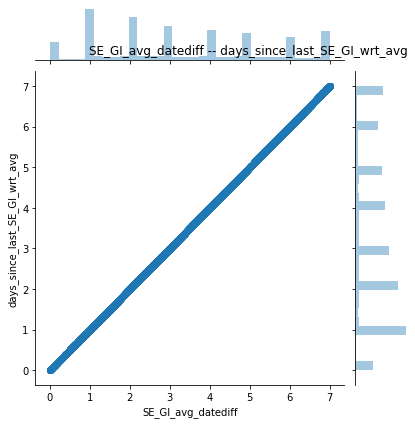

<Figure size 432x288 with 0 Axes>

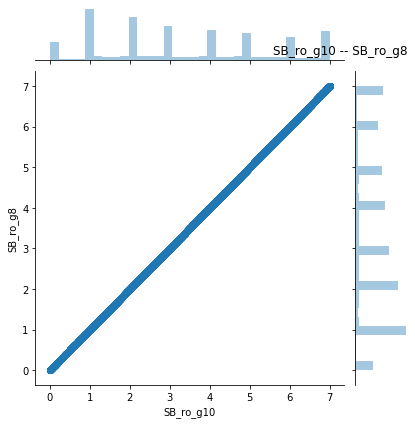

<Figure size 432x288 with 0 Axes>

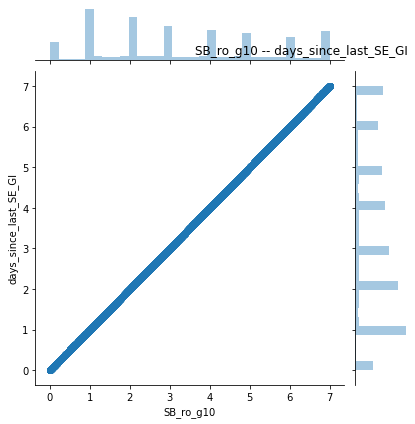

<Figure size 432x288 with 0 Axes>

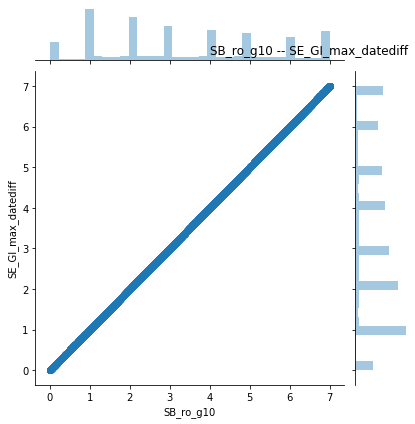

<Figure size 432x288 with 0 Axes>

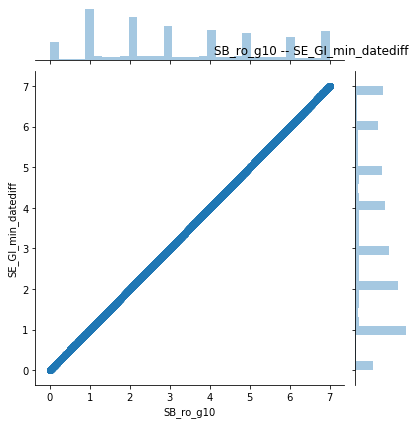

<Figure size 432x288 with 0 Axes>

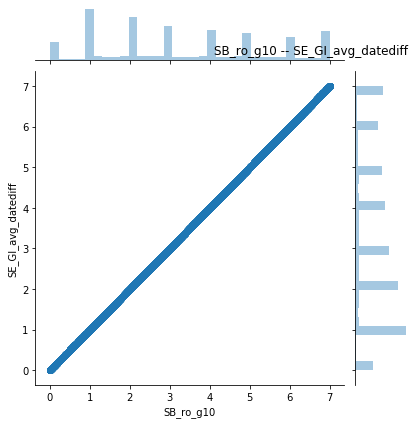

<Figure size 432x288 with 0 Axes>

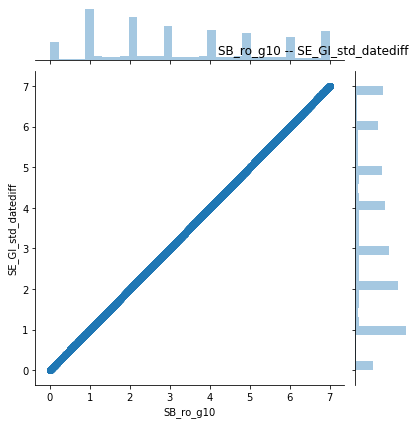

<Figure size 432x288 with 0 Axes>

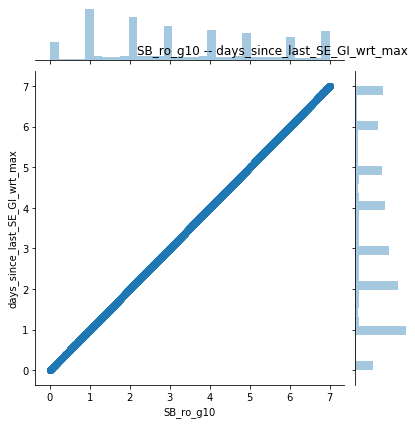

<Figure size 432x288 with 0 Axes>

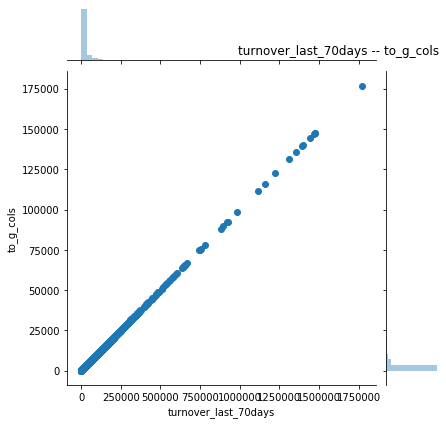

<Figure size 432x288 with 0 Axes>

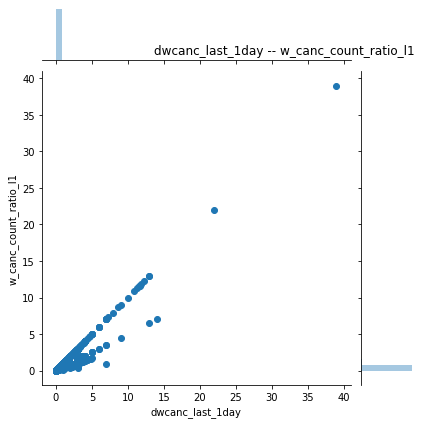

<Figure size 432x288 with 0 Axes>

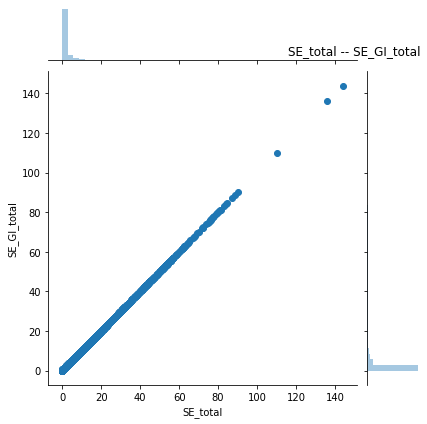

<Figure size 432x288 with 0 Axes>

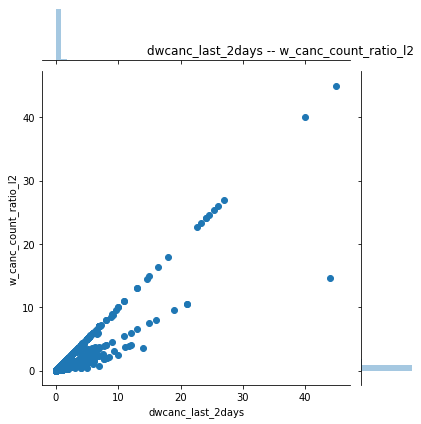

<Figure size 432x288 with 0 Axes>

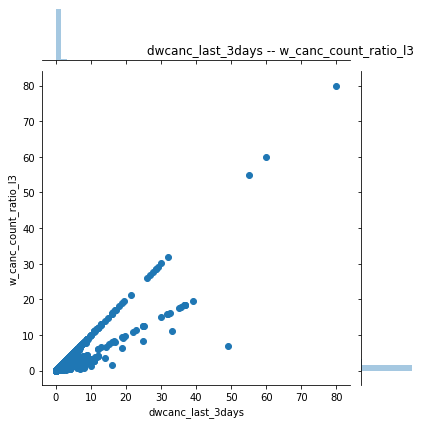

<Figure size 432x288 with 0 Axes>

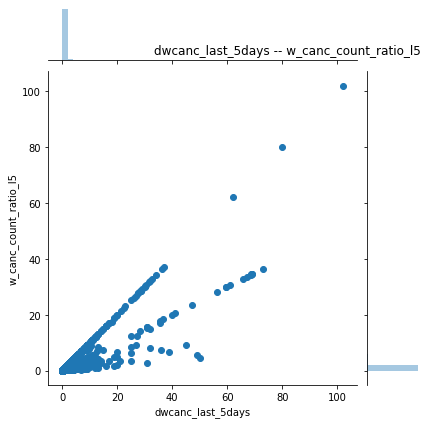

<Figure size 432x288 with 0 Axes>

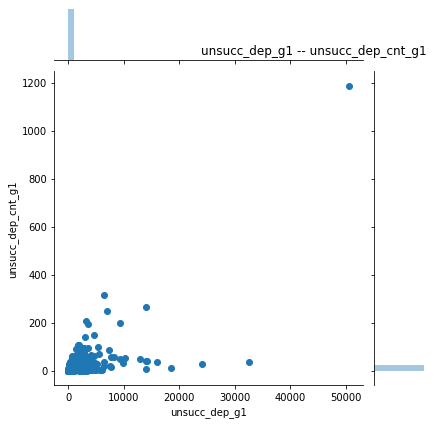

<Figure size 432x288 with 0 Axes>

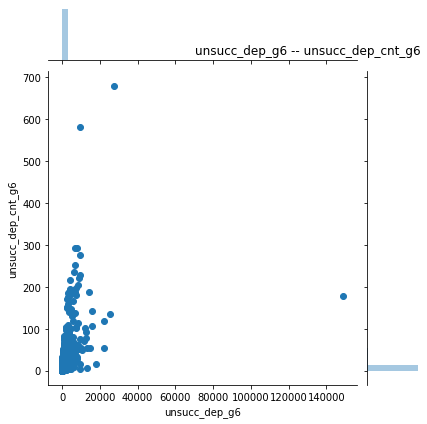

<Figure size 432x288 with 0 Axes>

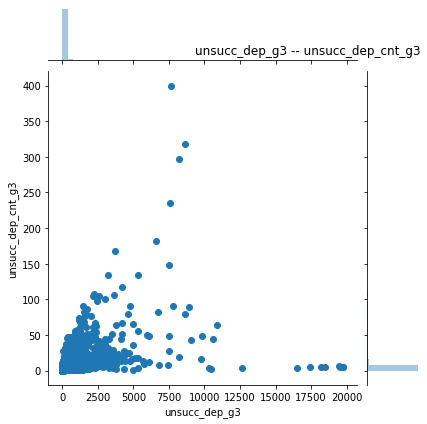

<Figure size 432x288 with 0 Axes>

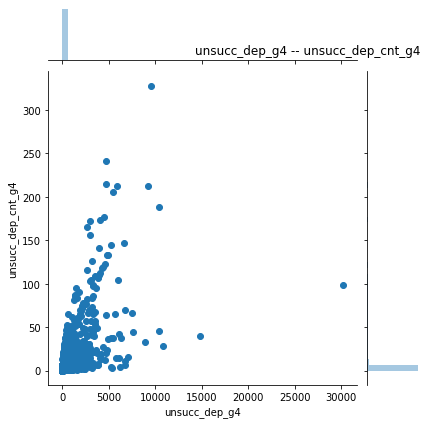

<Figure size 432x288 with 0 Axes>

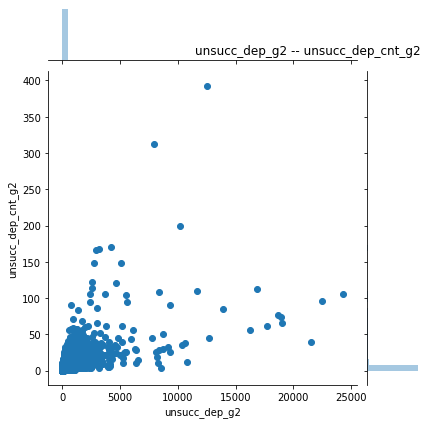

<Figure size 432x288 with 0 Axes>

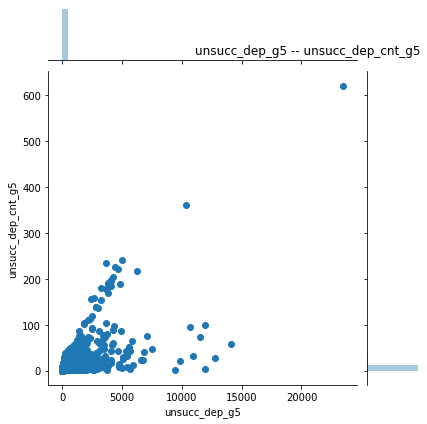

<Figure size 432x288 with 0 Axes>

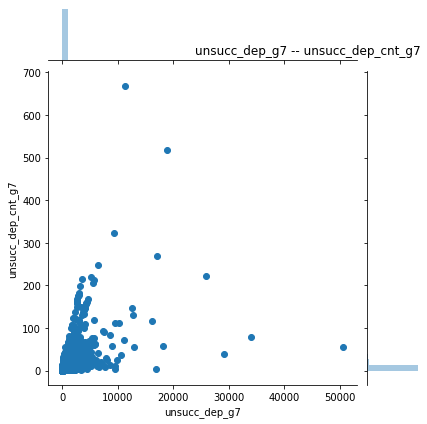

<Figure size 432x288 with 0 Axes>

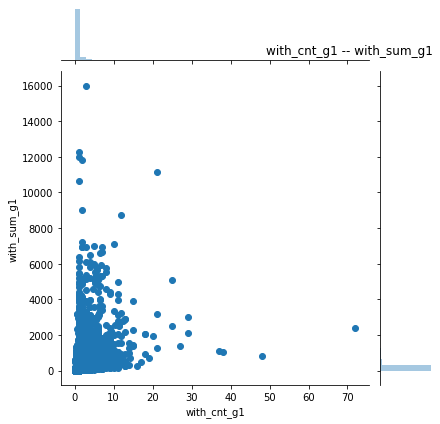

<Figure size 432x288 with 0 Axes>

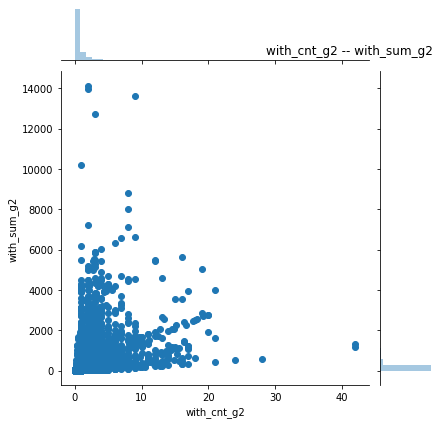

<Figure size 432x288 with 0 Axes>

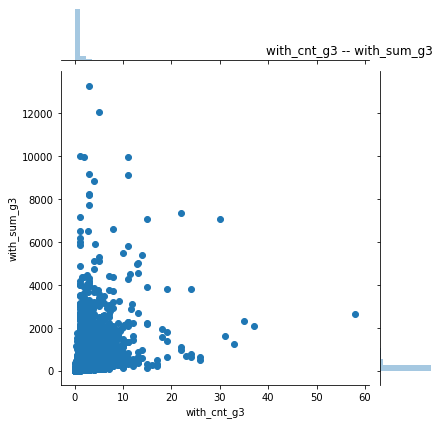

<Figure size 432x288 with 0 Axes>

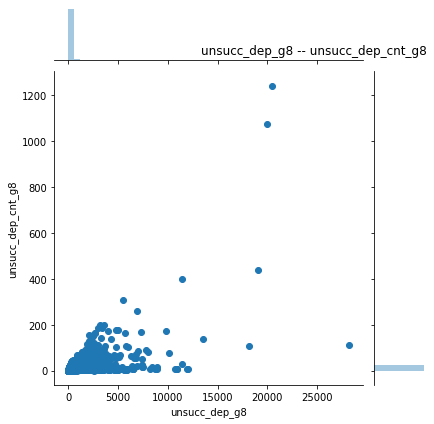

<Figure size 432x288 with 0 Axes>

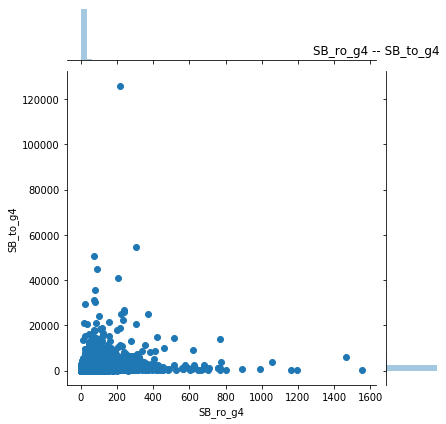

In [62]:
for x, y in colinear_pairs_tuple:
    plt.figure()
    sns.jointplot(train_set_reduced[x],train_set_reduced[y])
    plt.title(label = '{} -- {}'.format(x, y), pad = 17., loc ='right')
    plt.tight_layout()

We choose to remove the attributes that are highly correlated between each other - more than 98% -  and offer less predictability to a linear model.


In [29]:
# Set threshold for the correlation at 98% - We remove the attributes that offer less predictability to the model
colinear_pairs_tuple_rem_candidates = colinearity.loc[colinearity.values>0.98].index.tolist()

colinear_pairs_list_rem_candidates = set([x for y in colinear_pairs_tuple_rem_candidates for x in y])

Identify and choose the best attribute from each correlated tuple.

In [30]:
from sklearn.ensemble import ExtraTreesClassifier

# for each pair remove the less corellated to the target class
colinear_to_remove = list()
for pair in colinear_pairs_tuple_rem_candidates:
    model = ExtraTreesClassifier()
    df = train_set_reduced[[pair[0], pair[1], 'target']]
    model.fit(df.iloc[:, :-1],df.iloc[:, -1])
    res = model.feature_importances_
    if res[0]>res[1] and res[1] < 0.65:
        colinear_to_remove.append(pair[1])
    elif res[0]<res[1] and res[0] < 0.65:
        colinear_to_remove.append(pair[0])
    else:
        pass

In [32]:
# Attributes chosen to be removed
list(set(colinear_to_remove))

['unsucc_dep_g2',
 'unsucc_dep_g7',
 'dwcanc_last_2days',
 'days_g10',
 'SE_total',
 'w_canc_count_ratio_l5',
 'SB_to_g4',
 'with_sum_g2',
 'unsucc_dep_g1',
 'B_D_indicator',
 'ro_g10',
 'unsucc_dep_g5',
 'unsucc_dep_g6',
 'SB_ro_g8',
 'w_canc_count_ratio_l3',
 'SB_ro_g10',
 'unsucc_dep_g4',
 'to_g_cols',
 'unsucc_dep_g3',
 'w_canc_count_ratio_l1',
 'with_sum_g3',
 'with_sum_g1']

In [ ]:
# drop selected columns
train_set_reduced.drop(list(set(colinear_to_remove)), axis=1, inplace = True)

In [68]:
# Reorder columns
train_set_reduced = train_set_reduced[[x for x in train_set_reduced.columns.tolist() if x != 'target'] + ['target']]

Investigate some attributes in relation to the target class:

In [69]:
print("Skewness: ", train_set_reduced['target'].skew())

Skewness:  0.37346206579076674


View of what scikit ExtraTreesClassifier considers the top 20 attributes

In [ ]:
model = ExtraTreesClassifier()
model.fit(train_set_reduced.iloc[:, :-1],train_set_reduced.iloc[:, -1])

#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=train_set_reduced.iloc[:, :-1].columns)
feat_importances.nlargest(20).plot(kind='barh')
plt.show()

# Feature selection

## Ridge regression

In [ ]:
# Normalize training dataset
train_set_reduced = pd.concat([norm_(train_set_reduced.iloc[:, :-1]), train_set_reduced.iloc[:, -1]], axis = 1)
# Initialize
ridge = Ridge(alpha=1.0,  solver = 'svd')

x = ridge.fit(train_set_reduced.iloc[:, :-1], train_set_reduced.iloc[:, -1])
attr_ridge =pprint_coefs(ridge.coef_, names = train_set_reduced.columns.tolist(),  sort = True, tr=0.6)

In [132]:
#View of the attributes
attr_ridge 

['SE_total',
 'SE_GI_total_70days',
 'GOC_dist_gm_g9',
 'B_D_indicator',
 'SB_ro_g2',
 'GOC_to_g4',
 'unsucc_dep_cnt_g10',
 'bon_wrt_succdep_g9',
 'unsucc_dep_g9',
 'unsucc_dep_cnt_g1',
 'GOC_ro_g10',
 'succ_dep_cnt_g6',
 'SB_ro_g1',
 'dwcount_last_3days',
 'succ_dep_cnt_g2',
 'with_cnl_g7',
 'dwcount_last_1day']

We decide to replace the inf values with 1.01 due to the fact that this inf comes from a denomitaor equal to 0. In order  to retain the distribution of the dataset, we represent this infinitive with a value grater than 1 which demonstrates that this client loses money in a fast way 

In [139]:
# Replace np.inf values with 1.01
train_set_reduced['B_D_indicator'] = train_set_reduced['B_D_indicator'].replace([np.inf, -np.inf], 1.01)

# Logistics regression model

In [209]:
# Chosen columns
finalcolumns = attr_ridge  + ['target']
train_set_reduced_final = train_set_reduced[finalcolumns]
# define dataet model - downsampled
TrainingSet = train_set_reduced_final.to_numpy()
X_var = TrainingSet[:, :-1]
Y_var = TrainingSet[:, -1]

Hyper-parameters

In [226]:
# Initialize parameters
a = 0.005
# Iterations number
no_of_iter = 5000000

# Initialize Weights
W = np.random.uniform(low=-0.01, high=0.01, size=(X_var.shape[1]))

N = X_var.shape[0]
x_w=X_var.dot(W)

In [227]:
# Sigmoid Function
def Sigmoid_F(x_var, w):
    x_w = np.dot(x_var, w)
    return 1 / (1 + np.exp(-x_w))

def Loss(Y_var, sig_Y):
    return (-(Y_var*np.log(sig_Y)) -  ((1 - Y_var) * np.log(1 - sig_Y))).mean()

def Loss_derivative(sig_y, truth_y, x_matrix, N=N):
    dY =  sig_y - truth_y 
    return np.dot(dY, x_matrix)/N

In [ ]:
# Gradient Descent
for ii in range(no_of_iter):   
    # Sigmoid function output
    sig_Y = Sigmoid_F(X_var, W)
    # Loss Function
    L = Loss(Y_var, sig_Y)
    # Gradient computation
    dw = Loss_derivative(sig_y = sig_Y, truth_y = Y_var, x_matrix = X_var)
    # Update weights
    W = W - a * dw

    
print('Final Loss: ', L)

In [221]:
predictions =pd.DataFrame(columns = ['Index', 'call', 'Ground_Truth'])

print('number of calls: ', test_set.loc[test_set.target ==1].shape[0])

# Loop over the test set
for index, row in test_set.loc[:, finalcolumns].iterrows():
    prob = Sigmoid_F(row.tolist()[:-1], W)    
    if prob> 0.5:
        predictions = predictions.append({'Index':index, 'call': 1, 'Ground_Truth': row.tolist()[-1]  }, ignore_index=True )
    elif prob <= 0.5:
        predictions = predictions.append({'Index':index, 'call': 0, 'Ground_Truth': row.tolist()[-1]  }, ignore_index=True )
        

# Metrics
TP = predictions.loc[(predictions.call == 1) & (predictions.Ground_Truth == 1)].shape[0]
TN = predictions.loc[(predictions.call == 0) & (predictions.Ground_Truth == 0)].shape[0]
FP = predictions.loc[(predictions.call == 1) & (predictions.Ground_Truth == 0)].shape[0]
FN = predictions.loc[(predictions.call == 0) & (predictions.Ground_Truth == 1)].shape[0]

# Confusion Matrix
confusion_matrix = np.asarray([[TP, FP], [FN,TN]])

metrics_string = 'True Positives {}\n  True Negatives {}\n  False Positives {}\n  False Negatives {}'
print(metrics_string.format(TP, TN, FP, FN))

number of calls:  913


C:\Users\andre\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in exp
  after removing the cwd from sys.path.


True Positives 776
  True Negatives 15843
  False Positives 39950
  False Negatives 137


In [222]:
# Visualize confusion matrix
#confusion_matrix_visualization(confusion_matrix = confusion_matrix)

# Precision
Precision = TP/(TP + FP)
# Recall
Recall = TP/(TP + FN)
# Accuracy
Accuracy = (TP+TN)/(TP+TN+FP+FN)
#F1 Score
F_1 = 2*(Precision*Recall)/(Precision+Recall)

print('Precision {} \nRecall {} \nAccuracy {} \nF1 score {}'.format(Precision, Recall, Accuracy,  F_1 ))

Precision 0.019054166871286155 
Recall 0.8499452354874042 
Accuracy 0.29307304341692236 
F1 score 0.03727274910540598


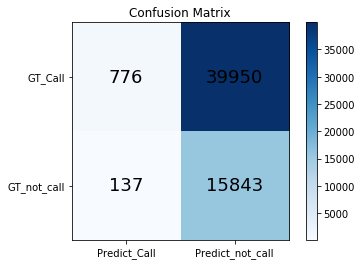

In [223]:
# Confusion Matrix
confusion_matrix = np.asarray([[TP, FP], [FN,TN]])
cm(confusion_matrix = confusion_matrix)

## Logistics regression Scikit

In [210]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

no_of_iter = 1000000
a = 0

logisticRegr = LogisticRegression(max_iter = no_of_iter)
logisticRegr.fit(X_var, Y_var)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Create the indictor custom indicator to the test set

In [202]:
# Create temporary columns per client
test_set['mean_ro_g_cols'] =test_set[SB_ro_g_cols].mean(axis=1)
test_set['mean_succ_dep_g_cols'] = test_set[succ_dep_g_cols].mean(axis=1)

# Create the indicator
test_set['B_D_indicator'] = test_set[with_sum_cols].mean(axis=1) / test_set[to_g_cols].mean(axis=1)

# remove inf
test_set['B_D_indicator'] = test_set['B_D_indicator'].replace([np.inf, -np.inf], 1.01)

In [216]:
# Split the Target class from the 
Y_test = np.array(test_set.loc[:, finalcolumns])[:, -1]
X_test = norm_(np.array(test_set.loc[:, finalcolumns ])[:, :-1])


In [212]:
predictions = logisticRegr.predict(X_test)
skl_precision_score = precision_score(Y_test, predictions )
skl_recall_score = recall_score(Y_test, predictions )
skl_accuracy_score = accuracy_score(Y_test, predictions )
skl_f1_score = f1_score(Y_test, predictions )

print(type(skl_f1_score))
TN, FP, FN, TP = confusion_matrix(Y_test.tolist(), predictions.tolist()).ravel()
print(TN, FP, FN, TP )
print("Precision {} \nRecall {} \nAccuracy {} \nF1 score {}".format(float(skl_precision_score), float(skl_recall_score), float(skl_accuracy_score), float(skl_f1_score)))
#InsertResult("SkLearn_Logistic_Regression", TrainingSetPercentage, no_of_iter, a, skl_precision_score, skl_recall_score, skl_accuracy_score, skl_f1_score, TP, TN, FP, FN)

<class 'numpy.float64'>
46202 9591 363 550
Precision 0.05423528251651711 
Recall 0.6024096385542169 
Accuracy 0.824463019786266 
F1 score 0.0995114890537362


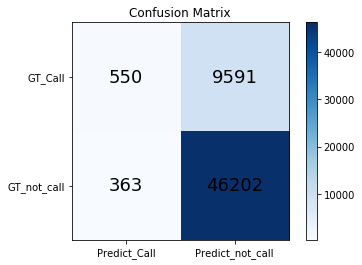

In [183]:
# Confusion Matrix
confusion_matrix = np.asarray([[TP, FP], [FN,TN]])
cm(confusion_matrix = confusion_matrix)

### Visualize Metrics

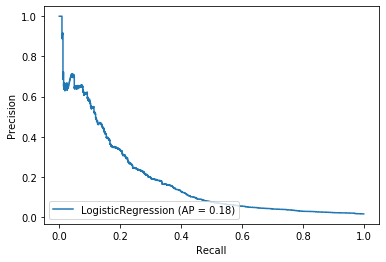

In [213]:
# precision Recall of model
disp = plot_precision_recall_curve(logisticRegr, X_test, Y_test)

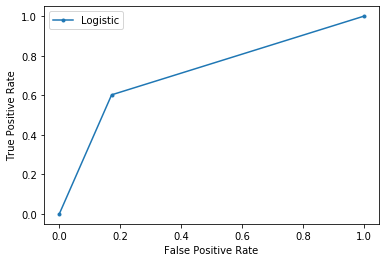

In [215]:
# ROC
# calculate scores
auc = roc_auc_score(Y_test, predictions)
fpr, tpr, _ = roc_curve(Y_test, predictions)
plt.plot(fpr, tpr, marker='.', label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()